<a href="https://colab.research.google.com/github/Joako360/Speaker-Recognition-Notebook/blob/main/Reconocimiento_del_hablante_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO DE PROCESAMIENTO DE SEÑALES - RECONOCIMIENTO DEL HABLANTE


Universidad Nacional de Lomas de Zamora

Facultad de Ingenieria

Profesores:
*  Ing. Simoncelli, Alejandro
*  Ing. Keienburg, Sebastian

Alumnos:
*  Gomez, Joaquin Nicolas
*  Rivera, Enzo Adriel



## Introducción
El presente trabajo abordara el poder reconocer a una persona a través de métodos de caracterización y modelos de entrenamiento de datos. Se creará una pequeña base de datos para realizar la prueba del script.

## Teoría base


### Voz humana
En la transmisión de la señal de voz, se asigna un ancho de banda de 4 kHz para cada canal, lo que significa que se puede transmitir información de audio con una frecuencia máxima de 4 kHz.  Para poder digitalizar y transmitir esta señal de voz, se utiliza una frecuencia de muestreo de 8 kHz (Teorema de Muestreo de Nyquist), lo que significa que se toman 8000 muestras de la señal de audio por segundo para su procesamiento y transmisión.

![](https://drive.google.com/uc?export=view&id=1RSkgxerOdPhdNBmZ-XICMtBMFOu5HAOm)

### Metodo MFCC
El metodo de coeficientes cepstrales en escala de Mel (MFCC por "Mel-Frequency Cepstral Coefficients") es utilizado para caracterizar muestras de voz y para su reconocimiento. Esta tecnica extrae caracteristicas del espectro de freciencia de una señal de audio, de forma que luego pueda clasificarse el mismo. En contraste con la escala lineal de frecuencia en Hertz (Hz), la escala de Mel asigna valores de frecuencia a lo largo de una escala que es más perceptualmente relevante para el oído humano.

La escala de Mel se basa en la forma en que el oído humano percibe los cambios en la frecuencia del sonido. Debido a la forma en que el oído interno funciona, los cambios en la frecuencia de las ondas sonoras se perciben como más grandes en las frecuencias más bajas que en las frecuencias más altas. Por lo tanto, la escala de Mel se construye utilizando una función no lineal que refleja esta relación no lineal entre los cambios en la frecuencia y la percepción auditiva.

La escala de Mel se divide en bandas de frecuencia, cada una de las cuales representa un rango de frecuencia perceptualmente uniforme. Esto significa que las bandas de frecuencia más bajas en la escala de Mel son más anchas que las bandas de frecuencia más altas, ya que los cambios de frecuencia son más notables a bajas frecuencias. La escala de Mel se utiliza a menudo en el procesamiento de señales de audio, incluyendo la extracción de características de señales de voz y música, ya que se ajusta mejor a la forma en que el oído humano percibe las diferencias de frecuencia en el sonido.

Para calcular los coeficientes MFCC, debes seguir los siguientes pasos:

1.   Obtener la señal de audio y dividirla en segmentos de tiempo (por ejemplo, 20-30 ms cada uno).

2.   Aplicar una ventana (por ejemplo, una ventana Hamming) a cada segmento para reducir el efecto de las discontinuidades al final de cada segmento.

3.   Calcular la Transformada de Fourier de cada segmento de audio y obtener su magnitud.

4.   Calcular el espectro de potencia del audio.

5.   Aplicar la escala Mel a los espectros de potencia, para hacer que las frecuencias sean más perceptualmente relevantes.

6.   Aplicar la Transformada de Coseno Discreta (DCT) a los espectros de potencia de la escala Mel para obtener los coeficientes cepstrales.

7.   Tomar los primeros N coeficientes cepstrales para representar la señal de audio.

![](https://drive.google.com/uc?export=view&id=1IO04iMAwQcYqcFwyl94L6ruFztBO_nYa)

## Script


### Librerias
Para la primer parte del programa importaremos los modulos de calculo y de reproduccion de audio de python

In [ ]:
!python --version
!pip install ffmpeg-python
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Python 3.10.12
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
import glob
import io
import os
import random
import sys #sys tiene funciones con el sistema operativo.
import wave #Wave para guardar archivos de audio.
from base64 import b64decode
from math import ceil, floor, sqrt

import ffmpeg
from google.colab import auth, output
output.enable_custom_widget_manager()
from IPython.display import Audio, clear_output, HTML, Math
import librosa
import matplotlib.pyplot as plt #Pyplot graficas e representaciones
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
mm = 1/25.4  # milímetros por pulgada
plt.rcParams['figure.figsize'] = [183*mm, 70*mm]
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['text.usetex'] = True
import numpy as np #NumPy para realiza operaciones numéricas
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sympy as sym
sym.init_printing()

# Importar PyDrive y librerias asociadas.
# Esto solo debe hacerse una vez por notebook.
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from scipy import signal, fft # SciPy se utiliza para procesamiento de señales.
from scipy.io.wavfile import read, write #Audio y read son utilizados para archivos de audio
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import cross_val_score, GridSearchCV

# Autenticacon y creación de un PyDrive client.
# Esto solo debe hacerse una vez por notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
FID = '1yEm8sWmi33bPZF9CqirGZdIM5RXf-H3i' #Joaquin's folder

AUDIO_HTML = """
<script>var my_div = document.createElement("DIV");
  var my_p = document.createElement("P");
  var my_btn = document.createElement("BUTTON");
  var t = document.createTextNode("Press to start recording");
  my_btn.appendChild(t);
  my_div.appendChild(my_btn);
  document.body.appendChild(my_div);
  var base64data = 0;
  var reader;
  var recorder, gumStream;
  var recordButton = my_btn;
  var handleSuccess = function(stream) {
    gumStream = stream;
    var options = {
      mimeType: 'audio/webm;codecs=opus'
    };
    recorder = new MediaRecorder(stream);
    recorder.ondataavailable = function(e) {
      var url = URL.createObjectURL(e.data);
      var preview = document.createElement('audio');
      preview.controls = true;
      preview.src = url;
      document.body.appendChild(preview);
      reader = new FileReader();
      reader.readAsDataURL(e.data);
      reader.onloadend = function() {
        base64data = reader.result;
      }
    };
    recorder.start();
  };
  recordButton.innerText = "Recording... press to stop";
  navigator.mediaDevices.getUserMedia({
    audio: true
  }).then(handleSuccess);

  function toggleRecording() {
    if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
    }
  }

  function sleep(ms) {
    return new Promise(resolve => setTimeout(resolve, ms));
  }
  var data = new Promise(resolve => {
    recordButton.onclick = () => {
      toggleRecording()
      sleep(1500).then(() => {
        resolve(base64data.toString())
        recordButton.innerText = "Success recording!"
      });
    }
  });</script>
"""

AUDIOPATH = "/content/audio_samples/"

### Funciones para conversion
Creamos distintas funciones para convertir unidades

In [ ]:
signal_to_power = lambda signal: signal ** 2
signal_to_power.__doc__="""
Calcula la potencia de una señal.

Parámetros:
signal (array-like): Una secuencia de numpy de muestras que representa la señal.

Retorna:
array-like: Una secuencia de valores que representa la potencia de la señal,
donde cada valor es el cuadrado de la muestra correspondiente en la señal de entrada.
"""


power_to_signal = lambda power: sqrt(power)
power_to_signal.__doc__="""
Calcula una señal en su forma original a partir de su potencia.

Parámetros:
power (array-like): Una secuencia de valores que representa la señal de potencia.

Retorna:
array-like: Una secuencia de valores que representa la señal original.

NOTA: Es imposible reconstruir una señal que fue elevada al cuadrado, eso solo es una aproximacion.
"""

signal_to_energy = lambda signal: np.sum(signal_to_power(signal))
signal_to_energy.__doc__="""
Calcula la energia total de una señal sumando la potencia de cada muestra.

Parámetros:
signal (array-like): Una secuencia de numpy de muestras que representa la señal.

Retorna:
float: Un valor que representa la energía total de la señal, obtenido sumando la potencia
de cada muestra en la secuencia de entrada.
"""


def power_to_db(ps, ref=1.0, top_db=80.0):
    """
    Convierte una potencia espectral a decibelios.
    Toma como entrada un valor de potencia y devuelve su equivalente en decibelios.

    Parámetros:

    ps (array-like): Potencia espectral.
    ref (float, optional): Referencia para la conversión a decibelios. Por defecto es 1.0.
    top_db (float, optional): Máxima atenuación en decibelios. Por defecto es 80.0.

    Retorno:

    power_db: array-like. La potencia espectral convertida a decibelios.

    Notas:
    - Manejo de ceros: Los valores de potencia iguales a cero se ajustan a un valor epsilon para evitar problemas
      en el cálculo del logaritmo.
    - La conversión a decibelios se realiza restando la referencia y aplicando una atenuación máxima.
    """
    #zero handling
    ps[ps==0] = np.finfo(float).eps
    db = 10.0 * np.log10(ps)
    db -= 10.0 * np.log10(ref)
    db = np.maximum(db, db.max() - top_db)
    return db

db_to_power = lambda db, ref=1.0: ref * np.power(10.0, 0.1 * db)
db_to_power.__doc__=    """
    Convierte una señal en decibelios a su equivalente señal de potencia.

    Argumentos:
    db (float o array-like): Valor en decibelios.
    ref (float, optional): Referencia para la conversión. Por defecto es 1.0.

    Retorna:
    power -- float o array-like, El valor convertido a su equivalente en potencia.

    Notas:
    - La conversión se realiza elevando 10 a la potencia de (db / 10) y multiplicando por la referencia.
    """


signal_to_db = lambda signal, ref=1.0: power_to_db(signal_to_power(signal), ref)
signal_to_db.__doc__=    """
    Convierte una señal de amplitud en su nivel de decibelios (dB).

    Args:
    signal (array-like): Señal de amplitud.
    ref (float, optional): Referencia para la conversión. Por defecto es 1.0.

    Returns:
    array_like: El nivel de decibelios (dB) de la señal.

    Notas:
    - La conversión se realiza calculando primero la potencia de la señal, luego aplicando la conversión a decibelios
      mediante la función power_to_db.
    """


db_to_signal = lambda db, ref=1.0: power_to_signal(db_to_power(db, ref))
db_to_signal.__doc__=    """
    Convierte una señal en decibelios a su valor de amplitud original.

    Parameters:
    db (float o array-like): Valor en decibelios.
    ref (float, optional): Referencia para la conversión. Por defecto es 1.0.

    Returns:
    numpy.ndarray: La señal en su valor de amplitud original.

    Notas:
    - La conversión se realiza aplicando la función db_to_power para obtener la potencia correspondiente,
      y luego se aplica la función power_to_signal para obtener la amplitud.
    """


hz_to_mel = lambda freq: 2595.0 * np.log10(1.0 + freq / 700.0)
hz_to_mel.__doc__="""
    Convierte una frecuencia en Hz a su equivalente en escala de Mel.

    Parámetros:

    freq (float): Frecuencia en Hz a convertir a escala de Mel.
    Retorno:

    mels (float): El valor de frecuencia convertido a escala de Mel.
    """

mel_to_hz = lambda mels: 700.0 * (10.0**(mels / 2595.0) - 1.0)
mel_to_hz.__doc__="""
    Convierte una frecuencia de Mel a su equivalente en Hz.

    Parámetros:

    mels (float): Frecuencia en Mel a convertir en Hz.
    Retorno:

    freq (float): El valor de frecuencia convertido a Hz.
    """

### Funciones Generales
Creamos distintas funciones para utilidad del programa

In [ ]:
def cargar_texto(filepath):  # usado para mostrar pangramas a leer en voz alta
    """
    Carga un archivo de texto y retorna su contenido como una lista con cada línea del archivo.

    Parámetros:
    filepath (str): Ruta al archivo de texto.

    Retorna:
    list: Una lista con cada línea del archivo de texto.
    """
    text_file = open(filepath, "r", encoding="utf-8")
    # Leer todas las líneas del archivo
    lines = text_file.readlines()
    text_file.close()
    # Devolver la lista de líneas
    return lines


def save_npz(file_name, npz_dict):
    """
    Guarda un diccionario de datos en formato NumPy .npz.

    Parámetros:
    file_name (str): El nombre del archivo .npz donde se guardarán los arrays.
    npz_dict (dict): Un diccionario con los nombres y arrays a guardar.
    """
    np.savez(file_name, **npz_dict)


def load_npz(file_name):
    """
    Carga un archivo en formato NumPy .npz y retorna un diccionario con los arrays guardados.

    Parámetros:
    file_name (str): El nombre del archivo .npz a cargar.

    Retorna:
    dict: Un diccionario con los contenidos guardados en el archivo .npz,
    donde las claves son los nombres de las variables y los valores son los arrays correspondientes.

    Notas:
    - La función utiliza NumPy para cargar el archivo .npz.
    - Se espera que el archivo contenga variables guardadas en formato de diccionario.
    """
    mfcc = np.load(file_name)
    return {name: mfcc[name] for name in mfcc}


def add_to_npz_dict(npz_dict, name, mfcc):
    """
    Añade un nuevo par name-mfcc al diccionario de datos NumPy (.npz).

    Parámetros:
    npz_dict (dict): Diccionario existente de datos NumPy al que se le agregará un nuevo elemento.
    name (str): Nombre del nuevo elemento a agregar al diccionario..
    mfcc (ndarray): Array de numpy asociados al nombre que se desea agregar al diccionario.

    Retorna:
    dict: El diccionario actualizado con el nuevo par name-mfcc.
    """
    npz_dict[name] = mfcc
    return npz_dict


def delete_from_npz_dict(npz_dict, name):
    """
    Elimina un elemento del diccionario de datos NumPy (.npz).

    Parámetros:
    npz_dict (dict): Diccionarioexistente de datos NumPy del que se eliminará un elemento.
    name (str): El nombre del elemento a eliminar del diccionario.

    Retorna:
    dict: El diccionario de numpy arrays actualizado sin el elemento eliminado.
    """
    del npz_dict[name]
    return npz_dict


def load_audio(audio_path, new_sr=None):
    """
    Carga un archivo de audio, normaliza su amplitud y opcionalmente realiza re-muestreo.

    Parámetros:
    audio_path (str): Ruta donde se encuentra el archivo de audio.
    new_sr (int, opcional): Nueva tasa de muestreo deseada. Si se proporciona, se realiza el re-muestreo.

    Retorna:
    tuple: Una tupla de dos elementos:
        s (ndarray): Datos del audio cargado y procesado.
        sr (int): Tasa de muestreo del archivo de audio en Hz.

    Notas:
    - La función utiliza la función `read` para cargar los datos del archivo de audio.
    - Normaliza la amplitud de la señal utilizando la función `normalize`.
    - Opcionalmente, aplica un filtro antialias y realiza re-muestreo si se proporciona una nueva tasa de muestreo.
    """
    old_sr, s  = read(audio_path)
    s = normalize(to_mono(s))
    if new_sr is not None:
      b, a = filter_design((new_sr / 2) - 1, old_sr) #Filtro antialias
      s = signal.lfilter(b, a, s)
      s = resample(s, old_sr, new_sr)
      sr = new_sr
    else:
      sr = old_sr
    return s, sr


def list_reg_names(files_list):
    """
    Obtiene los nombres de archivos sin extensión de una lista de archivos.

    Parámetros:
    files_list (list): Lista de diccionarios, donde cada diccionario representa un archivo.
                       Se espera que cada diccionario tenga una clave 'title' que contenga el nombre del archivo.

    Retorna:
    list: Una lista de nombres de archivos sin extensión.
    """
    names_list=[]
    for f in files_list:
      filename = f['title']
      if filename.endswith('.wav'):
        name = os.path.splitext(os.path.basename(filename))[0]
        print(name)
        names_list.append(name)
    return names_list


def add_reg_audio(local_download_path):
    """
    Realiza el proceso de registro de voz, solicitando al usuario su nombre, presentando instrucciones y oraciones
    para ser leídas en voz alta, grabando audio por al menos 15 segundos, guardando el archivo en formato WAV y
    subiéndolo a un directorio específico en Google Drive.

    Parámetros:
    - local_download_path (str): Ruta local donde se guarda el archivo de audio temporalmente.

    Retorna:
    VoiceSample: Objeto VoiceSample que contiene la señal de audio, la tasa de muestreo y el nombre del usuario.
    """
    name = input('Escriba su nombre para el registro:\n')#Nombre de la muestra de audio a tomar
    print("""
    Diga su nombre completo, su edad, y a continuación
    lea estas oraciones en voz alta y clara:
    """)
    print("- Acepto el uso de este audio para el registro de voz.")
    frases = cargar_texto("frases.txt")
    prev_frases = []
    for i in range(3):
      this_line = random.choice(frases)
      while this_line in prev_frases:
        this_line = random.choice(frases)
      print(this_line)
      prev_frases.append(this_line)
    s, sr = record()
    while (s.size / sr) < 15.0:
      print("El registro de voz es demaciado corto, debe durar al menos 15 segundos. Intentelo de nuevo.")
      s, sr = record()
    if name != '':
      filepath = AUDIOPATH + name + ".wav"
      write(filepath, sr, s.astype(np.int16) )
      f = drive.CreateFile({'parents': [{'id': FID}],'title':[name]})
      f.SetContentFile(filepath)
      f.Upload(param={'supportsTeamDrives': True})
    return VoiceSample(s, sr, name)

In [207]:

normalize = lambda s: s / np.max(abs(s)) # normalizar audio entre -1 y 1
    # dividir cada muestra del audio por la intensidad máxima
normalize.__doc__="""
    Normaliza los datos de audio para que tengan valores entre -1 y 1.

    Parámetros:
    s (ndarray): Los datos de audio a normalizar.

    Retorna:
    ndarray: Los datos de audio normalizados.
    """


def resample(s, old_sr, new_sr):
    """
    Resamplea los datos de audio a una nueva tasa de muestreo.

    Parámetros:
    s (ndarray): Señal de audio a resamplear.
    old_sr (int): La tasa de muestreo actual de los datos de audio.
    new_sr (int): La tasa de muestreo a la que se quieren resamplear los datos
    de audio.

    Retorna:
    ndarray: Los datos de audio resampleados a la nueva tasa de muestreo.
    """
    # calcular el número de muestras del audio resamplado
    Ns = round(len(s) * float(new_sr) // old_sr)
    return signal.resample(s, Ns)


def signals_energy_array(signal_list):
  """Calcula la energía de cada señal en una lista y retorna un array de energías."""
  energy_array = np.array([signal_to_energy(signal) for signal in signal_list])
  return energy_array


def trim_silence(s, sr, threshold=20, dt=0.2, plot=False):
    """
    Recorta las partes mudas de un audio.

    Parámetros:
    s (ndarray): Un array NumPy 1D de muestras de audio.
    threshold (int): El umbral mínimo para considerar que una muestra no es silenciosa [%].

    Retorna:
    ndarray: Un nuevo array 1D NumPy de muestras de audio con el silencio eliminado.
    """

    # Find all non-silent parts of the audio.
    nfft = 1
    while nfft < (sr*dt):
        nfft *= 2
    frames = frame_signal(s, nfft=nfft, hop_len=nfft)
    non_silent_parts = []
    E = signals_energy_array(frames)
    threshold = np.mean(E)*(threshold/100)
    for i in range(frames.shape[0]):
        if E[i] > threshold:#si el sample es menor al umbral (silencio)
            non_silent_parts.append(frames[i,:])

    # Concatenate all non-silent parts to form the trimmed audio.
    trimmed_audio = np.concatenate(non_silent_parts)
    if plot==True:
      plt.plot(E, label='Energia')
      plt.axhline(np.mean(E), linestyle='--', color='g', label='Energia Media')
      plt.axhline(threshold, linestyle='--', color='r', label='Threshold')
      plt.legend()
      plt.show()
    return trimmed_audio


def to_mono(s):
    """
    Trasforma la señarl Estereo a Mono. Si ya es Mono lo deja igual.

    Parametros:
    signal: audio de entrada

    Retorna:
    s Señal de audio en monoacustico.
    """
    if s.ndim > 1:
        s = np.mean(s, axis=1)

    return s


def additive_noise(s, fs, square_duty=0.01, square_amplitude=0.1, noise_amplitude=0.01):
    # Generar una onda cuadrada de 60 Hz
    N = len(s)
    t = np.arange(0, N / fs, 1 / fs)
    square_wave = signal.square(2 * np.pi * 60 * t, duty=square_duty)

    # Generar ruido blanco
    white_noise = np.random.normal(0, 1, N)

    # Mezclar el tono cuadrado con ruido blanco
    mixed_square = s + square_amplitude * square_wave
    mixed_noise = s + noise_amplitude * white_noise
    mixed_both = s + mixed_square + mixed_noise

    return mixed_square, mixed_noise, mixed_both


class VoiceSample:
    """
    Clase para trabajar con muestras de audio de voz.

    Atributos:
    sr (int): La tasa de muestreo de la muestra de audio.
    s (ndarray): Los datos de audio de la muestra.

    Métodos:
    init(self, s, sr): Inicializa la muestra de audio de voz. Si la muestra
    tiene más de un canal, se convierte a mono.
    resample(self, new_sr): Resamplea la muesta a una frecuencia de muestreo nuevo.
    """

    def __init__(self, s, sr, name=None):
        self.sr, self.s = sr, s
        self.name = name
        if self.s.ndim == 2:
            # convertir el audio a mono
            self.s = to_mono(self.s)


    def resample(self, new_sr):
        resample(self.s, self.sr, new_sr)


def preemphasis(s, coef=0.97):
    s_preemph = []
    for n in range(len(s)):
        s_preemph.append(s[n] - coef * s[n-1])
    return s_preemph


def deemphasis(s_preemph, coef=0.97):
    s = []
    for n in range(len(s)):
        s.append(s[n] + coef * s[n-1])
    return s


def delta(data, N=2, order=1, axis=1):
    if order < 1:
        raise ValueError("Orden de diferenciación no válido. Debe ser 1 o superior.")

    delta = data
    for i in range(order):
        delta = np.gradient(delta, N, axis=axis)
    return delta


## Filtros digitales
Un filtro digital es un sistema electrónico o algoritmo que procesa una señal digital para transformar dicha señal. Su función principal es seleccionar o rechazar componentes de frecuencia en una señal digital, permitiendo así la manipulación y el control de su espectro de frecuencia.

Existen diferentes tipos de filtros digitales, incluyendo filtros pasabajos, pasaaltos, pasabanda y rechazabanda, cada uno de los cuales tiene características y aplicaciones específicas.

El proceso de atenuación o amplificación de un rango de frecuencias determinado se logra mediante la manipulación de los coeficientes del filtro. Estos coeficientes determinan la forma y características de la respuesta de frecuencia del filtro. Al ajustar adecuadamente los coeficientes, se pueden crear filtros que atenúen o amplifiquen determinadas frecuencias según sea necesario.

### Ecuaciones en diferencias
Las ecuaciones en diferencias son una forma común de describir matemáticamente el comportamiento de un filtro digital. Estas ecuaciones representan una relación entre las muestras de entrada y salida de un filtro en términos de diferencias finitas de las muestras.

En general, las ecuaciones en diferencias se expresan de la siguiente manera:

$$y[n] = -a_{0}x[n] - a_{1}x[n-1] - a_{2}x[n-2] - ... + b_{1}y[n-1] + b_{2}y[n-2] + ...$$

Donde:
- $y[n]$ representa la muestra de salida en el instante n.
- $x[n]$ representa la muestra de entrada en el instante n.
- $a_{0}, a_{1}, a_{2}, ...$ son los coeficientes que multiplican las muestras de entrada.
- $b_{1},  b_{2}, ...$ son los coeficientes que multiplican las muestras de salida anteriores.

La ecuación en diferencias resumida en sumatorios se puede expresar de la siguiente manera:

$$y[n] = -\sum_{i=0}^{N} a_i x[n-i] + \sum_{i=1}^{M} b_i y[n-i]$$


Estas ecuaciones en diferencias describen cómo las muestras de entrada y salida están relacionadas en el dominio del tiempo discreto. Cada término de la ecuación representa una contribución específica de las muestras de entrada y salida anteriores, ponderadas por los coeficientes correspondientes.

Los coeficientes $a_{0}, a_{1}, a_{2}, ...$ y $b_{1},  b_{2}, ...$ determinan la respuesta del filtro y su comportamiento en el dominio de la frecuencia. Estos coeficientes se seleccionan de acuerdo con el tipo de filtro que se desea implementar y las características de atenuación o amplificación requeridas.

Al implementar un filtro digital, las ecuaciones en diferencias se utilizan para calcular las muestras de salida en función de las muestras de entrada y las muestras de salida anteriores. Estas ecuaciones pueden implementarse mediante algoritmos como el método directo, la convolución, la transformada Z o estructuras más avanzadas como los filtros de cascada o los filtros recursivos.

### Respuesta al impulso

La respuesta al impulso de un filtro digital se define como la salida del filtro cuando se le aplica un impulso unitario de entrada, definimos al impulso como una señal digital $\delta[n]$ cuya primera muestraen el instante n = 0 vale 1, y en todas las siguientes valen 0. Esta señal se caracteriza por poseer un espectro que cubre todas las frecuencias del rango audible de forma constante.

La respuesta al impulso del filtro, denotada como $h[n]$, se obtiene al establecer $x[n]=\delta[n]$, donde $\delta[n]$ es la función delta de Kronecker (impulso unitario discreto):
$$h[n]=y[n]$$

La respuesta al impulso de un filtro digital es una característica fundamental que describe su comportamiento en el dominio del tiempo.

La respuesta al impulso contiene información sobre la forma y las características del filtro. En el dominio del tiempo, muestra cómo el filtro responde a diferentes componentes de frecuencia presentes en la señal de entrada. En el dominio de la frecuencia, la respuesta al impulso se puede transformar utilizando la Transformada de Fourier para obtener la respuesta de frecuencia del filtro.

La respuesta al impulso es útil en el análisis y diseño de filtros digitales, ya que proporciona información sobre la respuesta en frecuencia, la estabilidad, la linealidad y otros aspectos del filtro. Además, la respuesta al impulso también se utiliza para implementar el filtro mediante convolución, ya que representa la secuencia de pesos que se aplican a las muestras de entrada para obtener la salida filtrada.



### Filtros FIR (Finite Impulse Response)

Un filtro FIR es un tipo de filtro digital en el que la respuesta al impulso tiene una duración finita. Esto significa que la salida de un filtro FIR solo depende de un número finito de muestras de entrada y de los coeficientes de entrada $b_i$. La respuesta al impulso del filtro FIR se extingue completamente después de un cierto número de muestras. Sólo consta de la parte no recursiva, vale decir que sólo utiliza muestras actuales y anteriores de la señal de entrada.

La ecuacion en diferencias entonces no tiene coeficientes para valores de entrada anteriores.

$$y[n] = \sum_{i=0}^{M} b_i x[n-i]$$

* Son siempre estables, lo que significa que su respuesta no se desborda o diverge.
* Tienen una fase lineal, lo que significa que no introducen distorsiones en la forma de onda de la señal filtrada.

### Filtros IIR (Infinite Impulse Response)

A diferencia de los filtros FIR, en un filtro IIR la respuesta al impulso puede tener una duración infinita. La salida de un filtro IIR puede depender tanto de muestras de entrada anteriores como de muestras de salida anteriores, lo que crea una retroalimentación. Esto significa que el filtro IIR tiene una memoria interna y puede tener una respuesta transitoria prolongada.

* Pueden tener una respuesta en frecuencia más suave en comparación con los filtros FIR.
* Pueden ser más eficientes computacionalmente, ya que requieren menos coeficientes para lograr una respuesta deseada.
* Pueden ser menos estables en comparación con los filtros FIR y pueden requerir técnicas adicionales, como la estabilización de polos, para evitar la inestabilidad.

| Característica | Filtro FIR | Filtro IIR |
| --- | --- | --- |
| Respuesta al impulso | Finita | Infinita |
| Dependencia de muestras anteriores | No | Sí |
| Estabilidad | Siempre estable | Dentro del ROC |
| Diseño de coeficientes | Determinados directamente mediante métodos de diseño | Determinados mediante polos y ceros |
| Memoria | No requiere almacenamiento de muestras anteriores | Requiere almacenamiento de muestras anteriores |
| Eficiencia computacional | Puede requerir más coeficientes para una respuesta precisa | Puede requerir menos coeficientes para una respuesta precisa |

### Filtros Digitales

Aqui se definen funciones ara generar filtros digitales, en este caso, filtros IIR del tipo o por método Butterworth

In [ ]:
def filter_design(cutoff, sr, order=5, btype='low'):
    """
    Diseña un filtro digital de Butterworth.

    Args:
        cutoff (float or list): Frecuencia(s) de corte del filtro.
        sr (float): Tasa de muestreo.
        order (int, opcional): Orden del filtro. Valor por defecto es 5.
        btype (str, opcional): Tipo de filtro ('low', 'high' o 'band'). Valor por defecto es 'low'.

    Returns:
        tuple: Coeficientes del filtro (b, a).

    Notas:
        - El parámetro cutoff puede ser una frecuencia única (para filtros 'low' o 'high') o una lista de dos
          frecuencias (para filtros 'band').
        - Los coeficientes del filtro se calculan utilizando la función signal.iirfilter de SciPy.
    """
    if btype not in ['low', 'high', 'band']:
        raise ValueError("Tipo de filtro no válido. Use 'low', 'high' o 'band'.")

    return signal.iirfilter(order, cutoff, btype=btype, ftype='butter', analog=False, fs=sr)

### Otras Funciones

###Grabar audio en Colab

In [ ]:
def record():
    """
    Graba audio desde el navegador y devuelve los datos de audio y la frecuencia de muestreo.

    Retorna:
    tuple: Una tupla con dos elementos:
        - audio (array-like): Datos de audio grabados.
        - sr (int): Frecuencia de muestreo del audio grabado en Hz.
    """
    display(HTML(AUDIO_HTML))
    data = output.eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output_, err = process.communicate(input=binary)

    riff_chunk_size = len(output_) - 8
    # Divide el tamaño del fragmento en cuatro bytes, retenidos en b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Reemplazo los bytes 4:8 en proc.stdout con el tamaño real del fragmento RIFF.
    riff = output_[:4] + bytes(b) + output_[8:]

    sr, audio = read(io.BytesIO(riff))

    return audio, sr

### Cargar audio de Drive a carpeta audio_samples Colab


In [127]:
# 1. Choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser(AUDIOPATH)
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'%s' in parents" % FID}).GetList()
suffixes = ('.wav',) #'.txt')
for f in file_list:
# 3. Create & download by id.
  if f['title'].endswith(suffixes):
    print('title: %s, id: %s' % (f['title'], f['id']))
    filepath = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(filepath))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(filepath)

vs_list = []
names_list = []
for filepath in sorted(glob.glob(os.path.join(AUDIOPATH, '*.wav'))):
    s, sr = load_audio(filepath, new_sr=16000)
    name = os.path.splitext(os.path.basename(filepath))[0]
    vs_list.append(VoiceSample(s, sr, name))
    names_list.append(name)
andrew = next(
    (vs for vs in vs_list if vs.name == 'andrew'),
    None
)
Audio(andrew.s, rate=andrew.sr)

title: enzo.wav, id: 1_KtHvPdOG2xr4d_35jj20WO5hWp9ZCJX
downloading to /content/audio_samples/enzo.wav
title: rocio.wav, id: 1UtfUUBFHkku3l96vw3bXCNAqMMUQEok6
downloading to /content/audio_samples/rocio.wav
title: Joaquin.wav, id: 13FrYA3x76jk2Kt6t_-UepYHYa2NNJ12n
downloading to /content/audio_samples/Joaquin.wav
title: Marta A.wav, id: 18OBeuKW0Y_bJWAzdJag68wMXoHtaLciZ
downloading to /content/audio_samples/Marta A.wav
title: andrew.wav, id: 1RT1YinKovhcPkDZpPf_1ey995fPkWqjr
downloading to /content/audio_samples/andrew.wav
title: arun.wav, id: 1l6-VAezw47ZhDEXedEDd6_-hUO3Ew4-K
downloading to /content/audio_samples/arun.wav
title: mitha.wav, id: 1WKcGbEyAbYvE4f6S0qQW846lqSn5oYUU
downloading to /content/audio_samples/mitha.wav


### Funcion para cargar y escuchar audio en el notebook

In [193]:
andrew_wav, andrew_wav_old_sr = load_audio(AUDIOPATH + 'andrew.wav')
Audio(andrew_wav, rate=andrew_wav_old_sr)

In [194]:
andrew_resample = resample(andrew_wav, andrew_wav_old_sr, 16000)
Audio(andrew_resample, rate=16000)

### Respuesta en frecuencia

 La Transformada de Fourier de la respuesta al impulso de un filtro digital se conoce como la respuesta en frecuencia del filtro. La respuesta en frecuencia proporciona información valiosa sobre cómo el filtro afecta las diferentes componentes de frecuencia de una señal de entrada.

$$\mathcal{F}\{h[n]\}=H[\omega]$$

La respuesta al impulso es la salida del filtro cuando se le aplica un impulso unitario como entrada. La Transformada de Fourier de la respuesta al impulso es una representación de cómo las diferentes frecuencias se ven afectadas por el filtro. Esta transformada muestra cómo el filtro atenúa o amplifica las diferentes componentes de frecuencia en la señal de entrada.

La respuesta en frecuencia se puede visualizar de dos maneras principales:

* **Magnitud de respuesta en frecuencia**: Muestra la amplitud de las diferentes componentes de frecuencia después de pasar por el filtro. Se representa gráficamente en un diagrama de magnitud en función de la frecuencia, generalmente en una escala logarítmica. Esta representación muestra qué tan bien el filtro atenúa o amplifica las diferentes frecuencias en relación con la frecuencia de referencia.

* **Fase de respuesta en frecuencia**: Muestra la diferencia de fase de las diferentes componentes de frecuencia después de pasar por el filtro. Se representa gráficamente en un diagrama de fase en función de la frecuencia. La fase puede ser importante en aplicaciones donde la precisión de la fase es crítica, como en el procesamiento de señales de audio o en aplicaciones de filtrado en tiempo real.

Un fasor es una forma simple de representar una señal sinusoidal en el dominio de la frecuencia.

In [131]:
def plot_freqz(b, a=1, sr=1.0):
    """
    Grafica la respuesta en frecuencia de un sistema de filtro digital.

    Parámetros:
        b (array_like): Coeficientes del numerador del filtro (numerator coefficients).
        a (array_like, opcional): Coeficientes del denominador del filtro (denominator coefficients). Valor por defecto es 1.
        sr (float, opcional): Tasa de muestreo. Valor por defecto es 1.0.

    Notas:
        - La función utiliza la función signal.freqz de SciPy para calcular la respuesta en frecuencia del filtro.
        - La magnitud de la respuesta en frecuencia se muestra en escala logarítmica en decibelios.
        - La fase de la respuesta en frecuencia se muestra en radianes desenrollados.
        - La frecuencia se representa normalizada respecto a π rad/muestra si la tasa de muestreo es 1.0, de lo contrario,
          se muestra en Hz.
        - Si la magnitud de la respuesta en frecuencia cae por debajo de -80 dB, el límite inferior del gráfico se establece en -80 dB.
    """
    w, h = signal.freqz(b, a, fs=sr)

    # Normaliza la frecuencia
    #w /= (2 * np.pi)

    fig, ax1 = plt.subplots()
    ax1.set_title('Respuesta en frecuencia del filtro')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')

    if plt.ylim()[0] < -80:
      ax1.set_ylim(bottom=-80)

    ax1.set_ylabel('Magnitud [dB]', color='b')

    if sr == 1.0:
      ax1.set_xlabel('Frecuencia normalizada [× $2\pi$ rad/muestra]')
    else:
      ax1.set_xlabel('Frecuencia [Hz]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Fase [radianes]', color='g')

    ax1.grid(True, alpha=0.5)
    plt.show()

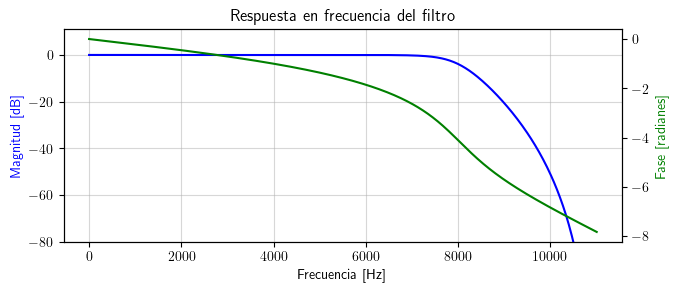

In [195]:
antialias_b, antialias_a = filter_design(7900, andrew_wav_old_sr) #Filtro antialias
plot_freqz(antialias_b, antialias_a, sr=andrew_wav_old_sr)

In [196]:
antialias_b, antialias_a

(array([0.22, 1.11, 2.22, 2.22, 1.11, 0.22]),
 array([1.00, 2.14, 2.26, 1.28, 0.39, 0.05]))

In [208]:
andrew_antialias = signal.lfilter(antialias_b, antialias_a, andrew_wav) #Filtro antialias
andrew_antialias = resample(andrew_antialias, andrew_wav_old_sr, 16000)
Audio(andrew_antialias, rate=16000)

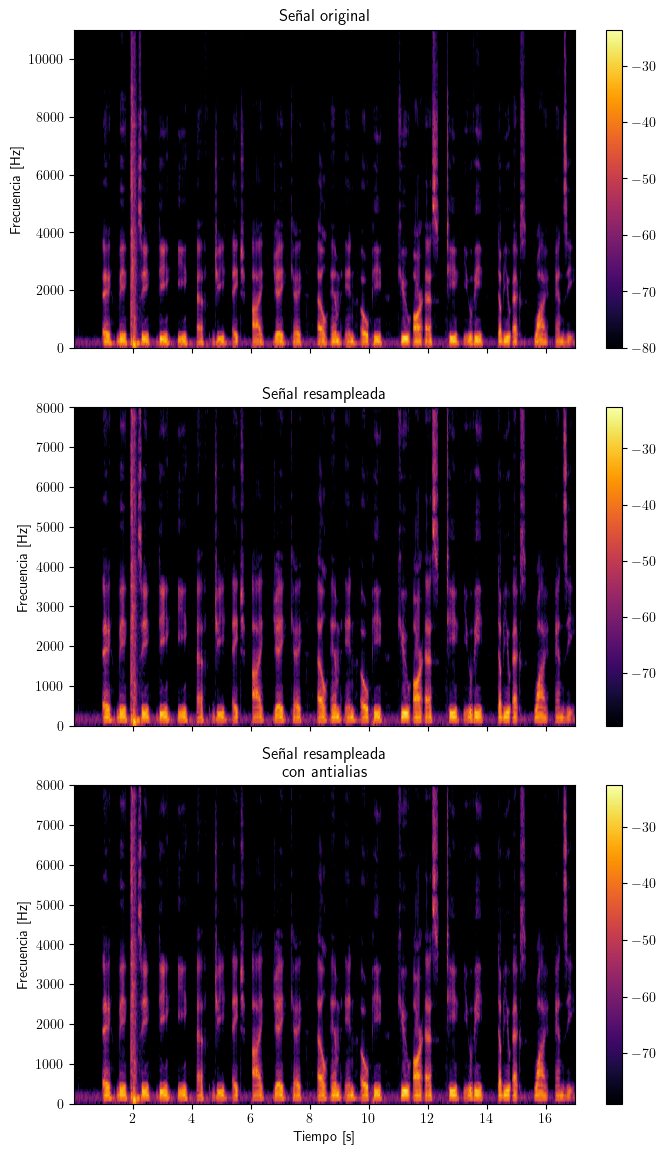

In [209]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=[183*mm, 296*mm], layout='tight')
cmap = plt.get_cmap('inferno')
cmap.set_under(color='k', alpha=None)

vmin = 20*np.log10(np.max(andrew_wav)) - 80  # hide anything below -80 dBc
pxx,  freq, t, cax = ax[0].specgram(andrew_wav, Fs=andrew_wav_old_sr, vmin=vmin, cmap=cmap)
ax[0].set_title("Señal original")
ax[0].set_ylabel("Frecuencia [Hz]")
#ax[0].set_ylim([0, 4000])
fig.colorbar(cax)

vmin = 20*np.log10(np.max(andrew_resample)) - 80  # hide anything below -80 dBc
pxx,  freq, t, cax = ax[1].specgram(andrew_resample, Fs=16000, vmin=vmin, cmap=cmap)
ax[1].set_title("Señal resampleada")
ax[1].set_ylabel("Frecuencia [Hz]")
fig.colorbar(cax)

vmin = 20*np.log10(np.max(andrew_antialias)) - 80  # hide anything below -80 dBc
pxx,  freq, t, cax = ax[2].specgram(andrew_antialias, Fs=16000, vmin=vmin, cmap=cmap)
ax[2].set_title("Señal resampleada\ncon antialias")
ax[2].set_ylabel("Frecuencia [Hz]")
fig.colorbar(cax)

plt.xlabel("Tiempo [s]")
plt.show()

### Preenfasis

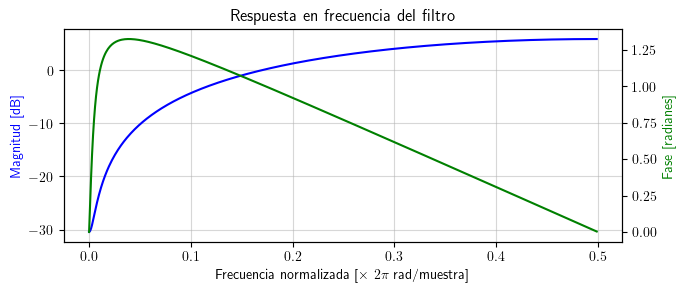

In [132]:
# Define los coeficientes del filtro de preénfasis
alpha = 0.97
b = np.array([1, -alpha])
a = np.array([1])

# Plotear la respuesta en frecuencia del filtro de preénfasis
plot_freqz(b, a)

In [212]:
andrew_preemph = preemphasis(andrew_antialias)

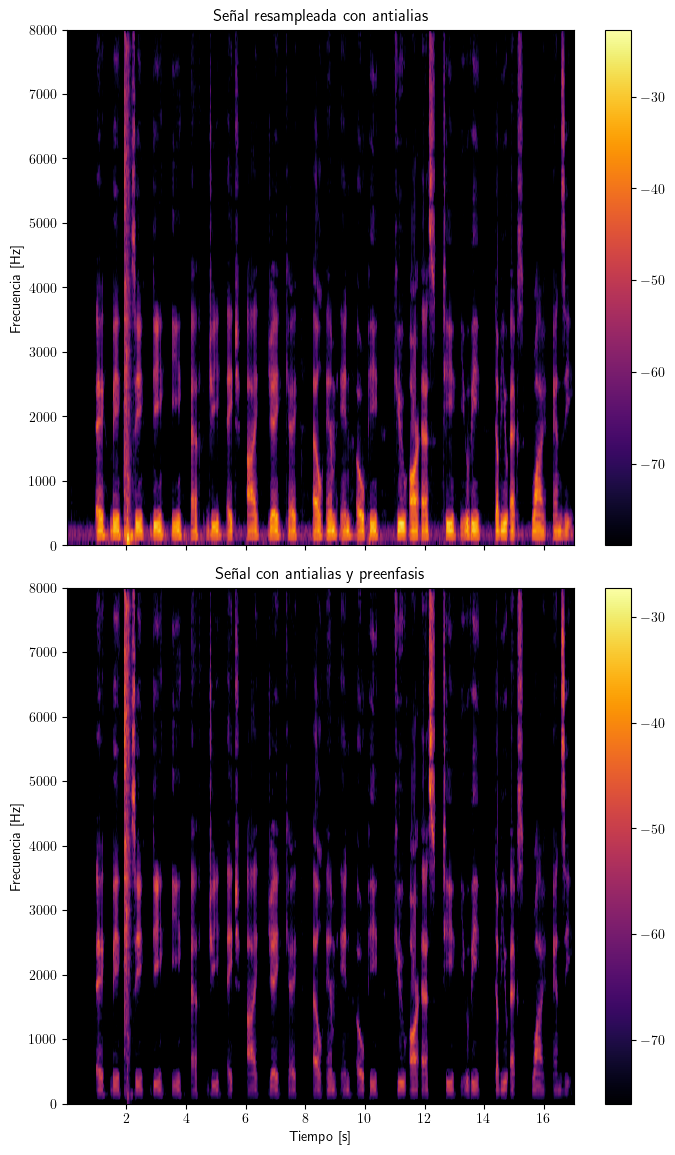

In [213]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=[183*mm, 296*mm], layout='tight')
cmap = plt.get_cmap('inferno')
cmap.set_under(color='k', alpha=None)

vmin = 20*np.log10(np.max(andrew_antialias)) - 80  # hide anything below -80 dBc
pxx,  freq, t, cax = ax[0].specgram(andrew_antialias, Fs=16000, vmin=vmin, cmap=cmap)
ax[0].set_title("Señal resampleada con antialias")
ax[0].set_ylabel("Frecuencia [Hz]")
#ax[0].set_ylim([0, 4000])
fig.colorbar(cax)

vmin = 20*np.log10(np.max(andrew_preemph)) - 80  # hide anything below -80 dBc
pxx,  freq, t, cax = ax[1].specgram(andrew_preemph, Fs=16000, vmin=vmin, cmap=cmap)
ax[1].set_title("Señal con antialias y preenfasis")
ax[1].set_ylabel("Frecuencia [Hz]")
fig.colorbar(cax)

plt.xlabel("Tiempo [s]")
plt.show()

In [214]:
Audio(andrew_preemph, rate=16000)

### Funcion para plotear señales

In [137]:
def plot_signal(s, sr, ax=None, plot_type=None, label=None):
    """
    Grafica una señal de audio en el dominio del tiempo.

    Parámetros:
    s (array-like): Datos de la señal de audio.
    sr (int): Tasa de muestreo de la señal de audio en Hz.
    ax (matplotlib.axes.Axes, optional): El objeto de ejes en el que se realizará la gráfica. Si no se proporciona, se crea uno.
    plot_type (str, optional): Tipo de gráfico ('plot', 'stem', 'step'). Por defecto, 'plot'.
    label (str, optional): Etiqueta para la leyenda del gráfico.

    Retorna:
    matplotlib.axes.Axes: El objeto de ejes en el que se realizó la gráfica.
    """
    N = len(s)
    duration = N / sr
    t = np.linspace(0, duration, num=N)
    if ax is None:
      fig, ax = plt.subplots()
    if plot_type == 'stem':
      ax.stem(t, s, linefmt='-', markerfmt='.', basefmt='k', label=label)
    elif plot_type == 'step':
      ax.step(t, s, where='post', label=label)
    else:
      ax.plot(t, s, label=label)
    ax.set_xlabel('Tiempo [s]'); ax.set_ylabel('Amplitud')
    if label is not None:
      ax.legend()
    ax.grid(True)
    return ax

###Entramado del audio

Dado que el audio es un proceso no estacionario, la FFT producirá distorsiones. Para superar esto podemos asumir que el audio es un proceso estacionario durante cortos periodos de tiempo. Por ello, dividimos la señal en tramas cortas. Cada trama de audio tendrá el mismo tamaño que la FFT. También queremos que las tramas se solapen. Lo hacemos para que las tramas tengan cierta correlación entre ellos y porque perdemos la información en los bordes de cada fotograma después de aplicar una función ventana.

In [138]:
def frame_signal(s, nfft=1024, hop_len=None, mode='constant'):
    """
    Divide una señal de audio en tramas utilizando la técnica de enventanado.

    Parámetros:
    s (array-like): Datos de la señal de audio.
    nfft (int, optional): Tamaño de la ventana (número de puntos de la FFT). Por defecto, 1024.
    hop_len (int, optional): Desplazamiento entre frames en número de muestras. Si no se proporciona, se elige como nfft // 2.
    mode (str, optional): Modo de relleno para la señal antes de dividirla en frames ('constant', 'reflect', 'symmetric', etc.). Por defecto, 'constant'.

    Retorna:
    array-like: Array 2D de frames, donde cada fila representa un frame de la señal.
    """
    # hop_len in number of samples
    hop_len = hop_len or nfft // 2
    s = np.pad(s, nfft // 2, mode=mode)
    num_frames = ceil((s.size - nfft) // hop_len) + 1
    frames = np.empty((num_frames, nfft))

    for n in range(num_frames):
        frames[n] = s[n * hop_len : (n * hop_len) + nfft]
    #dimensiones de frames: num_frames(filas) x nfft(columnas)
    return frames

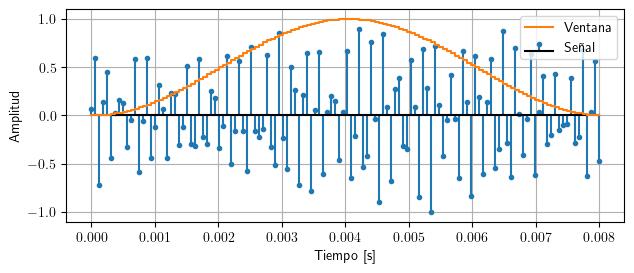

In [215]:
#Esto es un ejemplo para visualizacion
frames = frame_signal(andrew_preemph, nfft=128)
window = signal.get_window("hann", 128, fftbins=True)

E = signals_energy_array(frames)
test_frame = np.argmax(E)

fig, ax = plt.subplots()
ax = plot_signal(normalize(frames[test_frame]), andrew.sr, ax=ax, plot_type='stem', label='Señal')
ax = plot_signal(window, andrew.sr, ax=ax, plot_type='step', label='Ventana')
plt.show()

###Convertir al dominio de la frecuencia

Ahora convertiremos el audio, que actualmente está en el dominio del tiempo, al dominio de la frecuencia. La FFT asume que el audio es periódico y continúa. Al enmarcar la señal, nos aseguramos de que el audio sea periódico. Para hacer que el audio continúe, aplicamos una función ventana en cada trama. Si no lo hacemos, obtendremos distorsiones de alta frecuencia. Para superar esto, primero tenemos que aplicar una función de ventana al audio enmarcado y luego perforn FFT. La ventana asegura que ambos extremos de la señal terminen cerca de cero.

$$x_T[n]=x[n]w[n]$$
$$X_T[\omega]=\mathcal{F}\{x[n]\}*\mathcal{F}\{w[n]\}$$

La elección de la función de ventana tiene un impacto en la resolución espectral y en la capacidad de discriminación de señales cercanas en frecuencia. Idealmente, se busca una función de ventana que minimice el ancho del lóbulo principal y el decaimiento de los lóbulos secundarios.

In [140]:
def plot_window_response(windows, axs=None, labels=None):
    """
    Grafica las características de una o varias ventanas en el dominio del tiempo
    y su respuesta en frecuencia normalizada.

    Parámetros:
    windows (list or ndarray): Lista de ventanas a graficar. Puede ser una sola ventana o varias.
    axs (Axes, optional): Matrices de ejes de subgráficos de matplotlib. Si no se proporciona, se creará una nueva figura.
    labels (list, optional): Etiquetas para las ventanas, utilizadas en la leyenda.

    Retorna:
    Axes: Los ejes de subgráficos de matplotlib.
    """
    if type(windows) != list:
      windows = [windows]
    if axs is None:
      fig, axs = plt.subplots(2,1, layout='tight')

    for i, win in enumerate(windows):
      if labels is not None:
        label = labels[i]
      else:
        label = None
      # Graficar la ventana en el dominio del tiempo
      axs[0].plot(win, label=label)

    axs[0].set_title('Dominio del tiempo de la ventana')
    axs[0].set_ylabel('Amplitud'); axs[0].set_xlabel('Muestra')
    if labels is not None:
      axs[0].legend()
    axs[0].grid(True)

    # Calcular la respuesta en frecuencia de la ventana
    A = [0]*len(windows); response = [0]*len(windows)
    for i, win in enumerate(windows):
      A[i] = fft.fft(win, 2048) / (len(win)/2.0)
      response[i] = abs(fft.fftshift(A[i] / abs(A[i]).max()))
      response[i] = 20 * np.log10(np.maximum(response[i], 1e-10))
    freq = np.linspace(-0.5, 0.5, len(A[0]))

    # Graficar la respuesta en frecuencia de la ventana
    for i, win in enumerate(windows):
      if labels is not None:
        label = labels[i]
      else:
        label = None
      axs[1].plot(freq, response[i], label=label)

    axs[1].axis([-0.5, 0.5, -120, 0])
    axs[1].set_title('Respuesta en frecuencia de la ventana')
    axs[1].set_ylabel('Magnitud [dB]')
    axs[1].set_xlabel('Frecuencia normalizada [ciclos por muestra]')
    if labels is not None:
      axs[1].legend()
    axs[1].grid()

    return axs

Veremos una comparativa entre las diferentes ventanas.

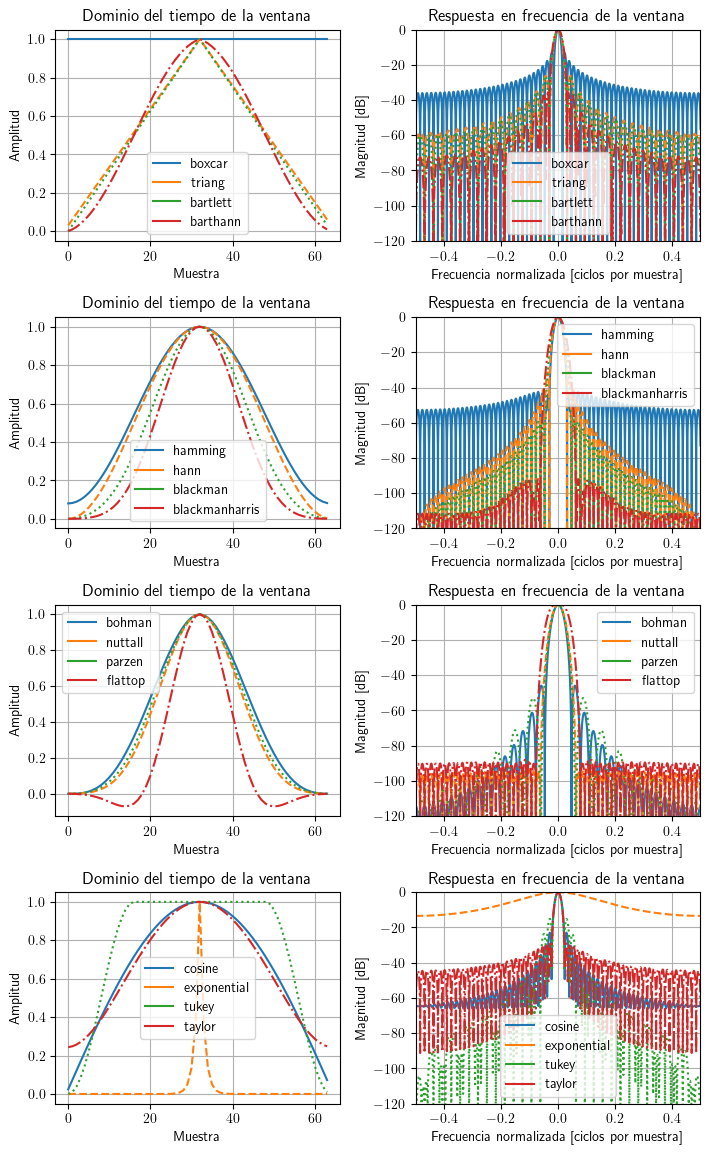

In [ ]:
# Ejemplo de uso: graficar la respuesta en frecuencia de la ventana Hann
windows_list = ['boxcar', 'triang', 'bartlett', 'barthann',
                'hamming', 'hann', 'blackman', 'blackmanharris',
                'bohman', 'nuttall', 'parzen', 'flattop',
                'cosine', 'exponential', 'tukey', 'taylor', 'lanczos']
win_fn_list = [signal.get_window(window,64) for i, window in enumerate(windows_list)]

fig, axs = plt.subplots(4,2, figsize=[183*mm, 296*mm], layout='tight')
axs[0,:] = plot_window_response(  win_fn_list[:4] , axs=axs[0,:], labels=windows_list[:4])
axs[1,:] = plot_window_response( win_fn_list[4:8] , axs=axs[1,:], labels=windows_list[4:8])
axs[2,:] = plot_window_response( win_fn_list[8:12], axs=axs[2,:], labels=windows_list[8:12])
axs[3,:] = plot_window_response(win_fn_list[12:-1], axs=axs[3,:], labels=windows_list[12:-1])
# Alternar estilos de línea
line_styles = ['-', '--', ':', '-.']
for i, ax in enumerate(axs.flatten()):
    lines = ax.get_lines()
    for j, line in enumerate(lines):
        line.set_linestyle(line_styles[j % len(line_styles)])
fig.tight_layout()
plt.show()

En esta comparativa podemos destacar 2 diferencias principales:
* **El ancho del lobulo principal**: El ancho del lobulo principal es clave para la resolucion espectral de dos sinusoides cercanas entre si en frecuencias. Esto es, cuanto mas angosto sea el lobulo principal, mejor resolucion de frecuencias cercanas tendra.
* **El decaimiento de los lobulos secundarios**: Esta caracteristica permite la discriminacion de una sinusoide de baja potencia respecto de otra. Un decaimiento rapido de lobulos secundarios resulta en una mejor deteccion de señal de baja potencia.

1.  **Ventana rectangular**: La ventana rectangular tiene un ancho
de lóbulo principal amplio y presenta lóbulos secundarios pronunciados. Aunque es fácil de implementar, no es la opción ideal en términos de resolución espectral.

2.  **Ventana de Hamming**: La ventana de Hamming ofrece un compromiso entre el ancho del lóbulo principal y el decaimiento de los lóbulos secundarios. Proporciona una buena atenuación de los lóbulos secundarios, pero aún tiene un ancho de lóbulo principal relativamente amplio.

3.  **Ventana de Blackman**: La ventana de Blackman ofrece un mejor decaimiento de los lóbulos secundarios que la ventana de Hamming, lo que resulta en una mejor discriminación de señales cercanas en frecuencia. Sin embargo, el ancho del lóbulo principal sigue siendo más amplio que en algunas otras ventanas más avanzadas.

Elegir la ventana correcta es difícil y lleva tiempo. Para simplificar, elegiremos la ventana de Hanning, que se define como:
$$ w_H(n) = 0.5 - 0.5 \cos\left(\frac{2\pi{n}}{M-1}\right)\qquad 0 \leq n \leq M-1$$

In [141]:
def window_signal(s, nfft=1024, hop_len=None, window="hann"):
    """Aplica una ventana a cada frame de una señal de audio.

    Parámetros:
    s (array): La señal de audio a dividir en frames y aplicar la ventana.
    nfft (int): El tamaño de cada frame, debe ser potencia de 2.
    window (str o array): Tipo de ventana a aplicar. Si es una cadena, debe
        ser una de las opciones disponibles en scipy.signal.get_window.
        También se puede proporcionar un array que represente una ventana
        a medida.
    hop_len (int): La cantidad de muestras que se traslaparán entre dos frames
        consecutivos.

    Retorna:
    array: Un array de frames de la señal de audio con ventana aplicada.

    """
    s_framed = frame_signal(s, nfft=nfft, hop_len=hop_len)
    window = signal.get_window(window, nfft, fftbins=True)
    s_win = s_framed * window
    return s_win

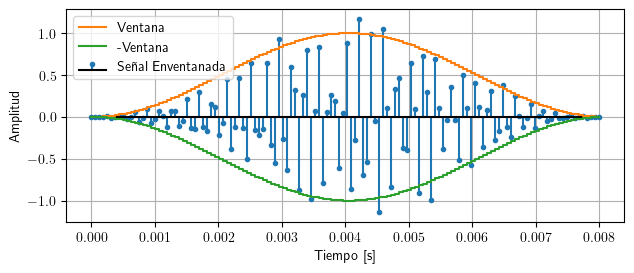

In [217]:
andrew_window = window_signal(andrew_preemph, nfft=128)

fig, ax = plt.subplots()
ax = plot_signal(andrew_window[test_frame],andrew.sr, ax=ax, plot_type='stem', label='Señal Enventanada')
ax = plot_signal(window,andrew.sr, ax=ax, plot_type='step', label='Ventana')
ax = plot_signal(-window,andrew.sr, ax=ax, plot_type='step', label='-Ventana')
plt.show()

En el gráfico de arriba se puede ver que los dos extremos de la trama terminan en lugares diferentes del eje y. Puedes ver que la ventana acercó los bordes de cada trama a cero.

Ahora vamos a realizar la FFT. Después de hacer la FFT sólo tomamos la parte positiva del espectro (primera mitad +1).

## Transformada de Fourier


**Frecuencia de muestreo**: La frecuencia de muestreo se refiere a la cantidad de muestras tomadas por segundo al digitalizar una señal analógica. Se expresa en muestras por segundo o, más comúnmente, en hercios (Hz). La frecuencia de muestreo es crucial para asegurar la representación adecuada de una señal continua en el dominio digital.

El teorema de muestreo de Nyquist-Shannon establece que la frecuencia de muestreo debe ser al menos el doble de la frecuencia máxima contenida en la señal analógica para evitar la aparición de aliasing. Esto se conoce como la frecuencia de Nyquist. Si la señal de interés tiene una frecuencia máxima de Fmax, se recomienda una frecuencia de muestreo de al menos 2 * Fmax para obtener una representación precisa de la señal.

Si la frecuencia de muestreo es demasiado baja en relación con la frecuencia máxima de la señal, se producirá un fenómeno llamado aliasing, donde las frecuencias más altas se superponen y se confunden con frecuencias más bajas, generando distorsiones en la señal muestreada.

**Transformada de Fourier**: La transformada de Fourier es una herramienta matemática que permite descomponer una señal en sus componentes de frecuencia. En el contexto del procesamiento de señales digitales, la transformada de Fourier se aplica a una señal discreta para obtener su representación en el dominio de la frecuencia.

La transformada de Fourier discreta (DFT) es la versión discreta de la transformada de Fourier y se utiliza ampliamente en el procesamiento de señales digitales. La DFT toma una secuencia de muestras en el dominio del tiempo y la descompone en sus componentes espectrales correspondientes.

La DFT produce un espectro discreto de amplitudes y fases, donde cada componente espectral representa una frecuencia específica presente en la señal. La DFT es simétrica y devuelve información en ambos lados del espectro, conocido como espectro de dos caras. Sin embargo, en muchas aplicaciones, solo se considera el espectro de una cara, que muestra las frecuencias positivas.

En cuanto a las características de simetría de la transformada de Fourier, estas están relacionadas con la propiedad de la transformada conocida como simetría hermítica o conjugada. En el caso de la DFT, la transformada discreta de Fourier, hay dos tipos de simetría:

* Simetría hermítica: Si la señal en el dominio del tiempo es una secuencia real, es decir, no contiene componentes imaginarias, entonces el espectro resultante de la DFT es conjugadamente simétrico. Esto significa que los coeficientes en frecuencias negativas son el conjugado complejo de los coeficientes en frecuencias positivas. En otras palabras, el espectro tiene una simetría respecto al centro.

* Periodicidad de la DFT: la Transformada de Fourier Discreta (DFT) es periódica y se repite cada múltiplo de la frecuencia de muestreo. A medida que aumenta la frecuencia, la representación en el dominio de la frecuencia se repite periódicamente debido a la naturaleza discreta del análisis.
Esto está relacionado con la relación entre la frecuencia de muestreo y la frecuencia máxima de la señal.

Veamos cómo ocurre esto y cómo está relacionado con el aliasing.

Cuando se aplica la DFT a una secuencia de muestras en el dominio del tiempo, se obtiene un espectro discreto en el dominio de la frecuencia. La DFT considera que la secuencia de entrada es periódica, repitiéndose infinitamente en el tiempo. Esto implica que el espectro resultante también es periódico.

La longitud de la secuencia de entrada en la DFT determina la resolución en frecuencia. Si la secuencia tiene N muestras, el espectro resultante tendrá N componentes espectrales. La resolución en frecuencia, es decir, la distancia entre dos componentes espectrales adyacentes, está determinada por la frecuencia de muestreo (Fs) y la longitud de la secuencia (N). Se puede calcular como Fs/N.

Cuando la frecuencia de muestreo es baja en relación con las frecuencias presentes en la señal, ocurre el aliasing. El aliasing se produce cuando las componentes espectrales de la señal se superponen y confunden en el espectro resultante debido a una mala representación de las frecuencias.

En el caso de la DFT, el aliasing se manifiesta en forma de "desbordamiento" o "plegado" de las frecuencias. Si una frecuencia en la señal original excede la frecuencia de Nyquist (la mitad de la frecuencia de muestreo), se verá reflejada como una frecuencia más baja en el espectro, dentro del rango permitido. Esto se debe a que la DFT asume una periodicidad infinita y no puede distinguir entre frecuencias más altas que la frecuencia de Nyquist y sus réplicas.

Por ejemplo, si tienes una señal de frecuencia f que es mayor que la frecuencia de Nyquist (Fs/2), entonces su representación en la DFT se verá "plegada" hacia abajo en el espectro. La frecuencia f se reflejará como f' = Fs - f. Este fenómeno produce aliasing y distorsiona la representación espectral de la señal.

Para evitar el aliasing, es necesario aplicar un filtro anti-aliasing antes del proceso de muestreo, que limita las frecuencias presentes en la señal de entrada a un rango adecuado que esté dentro de las capacidades de la frecuencia de muestreo.

La relación entre la frecuencia de muestreo y la transformada de Fourier se basa en el teorema de muestreo de Nyquist-Shannon. Según este teorema, para evitar el aliasing y garantizar una representación precisa de la señal analógica, la frecuencia de muestreo debe ser al menos el doble de la frecuencia máxima contenida en la señal. Esto implica que la frecuencia de muestreo debe ser mayor que la frecuencia de Nyquist. Si se cumple esta condición, se puede realizar una reconstrucción adecuada de la señal original mediante la transformada de Fourier inversa.

### Rutina para plotear transformada de fourier

In [143]:
def plot_fft(s, sr, ax=None, label=None, dtype=None):
    """
    Grafica la transformada de Fourier de una señal de audio en el dominio de la frecuencia.

    Parámetros:
    s (ndarray): La señal de audio.
    sr (int): Tasa de muestreo de la señal en Hz.
    ax (Axes, optional): Ejes de la figura de matplotlib. Si no se proporciona, se creará una nueva figura.
    label (str, optional): Etiqueta para la leyenda.
    dtype (str, optional): Tipo de representación ('freq' para frecuencia, 'time' para tiempo, None para predeterminado).

    Retorna:
    Axes: Los ejes de la figura de matplotlib.
    """
    N =s.size
    if dtype == 'freq':
      S = s
      freq = np.linspace(0, sr // 2, N)
    elif dtype == 'time' or dtype == None:
      S = abs(np.fft.rfft(s))*2/N
      freq = np.fft.rfftfreq(N, d=1 / sr)
    else: return

    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(freq, S, label=label)
    ax.set_xlabel('Frecuencia [Hz]');ax.set_ylabel('Magnitud')
    ax.set_title('Audio Signal FFT')
    if label is not None:
      ax.legend()
    ax.grid(True)
    return ax

### Principio de incertidumbre
El funcionamiento de un espectrograma permite obtener informacion en tiempo y en frecuencia, sacrificando resolucion en un eje para precisarlo sobre el otro. Es imposible tener total certeza sobre ambas magnitudes, más bien se busca un balance entre estas con un margen de error.
$$\Delta t = \frac{M}{f_s}$$
$$\Delta f = \frac{f_s}{M}$$
$$\Delta t \Delta f = \text{constante}$$

In [144]:
def stft(s, nfft=1024, hop_len=None, window='hann'):
    """
    Calcula la Transformada de Fourier de Tiempo Corto (STFT) de una señal de audio.

    Parámetros:
    s (ndarray): La señal de audio.
    nfft (int, optional): Tamaño de la ventana de transformada de Fourier. Por defecto es 1024.
    hop_len (int, optional): Tamaño del salto entre ventanas sucesivas. Si no se proporciona, se usa nfft // 2.
    window (str, optional): Tipo de ventana a aplicar ('hann', 'hamming', etc.). Por defecto es 'hann'.

    Retorna:
    ndarray: La magnitud de la STFT de la señal, representada como una matriz.
    """
    hop_len = hop_len or nfft // 2
    s_win = window_signal(s, nfft=nfft, hop_len=hop_len, window=window)
    n_frames = s_win.shape[0]
    S_fft = np.empty((n_frames, 1 + nfft // 2), dtype=np.complex64, order='F')

    for n in range(n_frames):
      N = S_fft.shape[1]
      frame = s_win[n, :]
      S_fft[n, :] = np.fft.rfft(frame, n=nfft, axis=-1)[:N]*2/N
    # Dimensiones de la matriz de salida: (n_frames, 1 + nfft // 2)
    return np.abs(S_fft, dtype=np.float32)


def powspec(Spect, nfft=1024):
    """
    Calcula la densidad espectral de potencia a partir de un espectrograma.

    Parámetros:
    Spect (array): Espectrograma de magnitudes.
    nfft (int, opcional): Tamaño de la ventana de la FFT.

    Retorna:
    array: Densidad espectral de potencia.
    """
    return Spect ** 2 / nfft


def logpowspec(Spect, nfft=1024, norm=True):
    """
    Calcula el logaritmo de la densidad espectral de potencia a partir de un espectrograma.

    Parámetros:
    Spect (array): Espectrograma de magnitudes.
    nfft (int, opcional): Tamaño de la ventana de la FFT.
    norm (bool, opcional): Normalizar el resultado restando el valor máximo.

    Retorna:
    array: Logaritmo de la densidad espectral de potencia.
    """
    ps = powspec(Spect, nfft=nfft)
    lps = power_to_db(ps)
    if norm:
      return lps - np.max(lps)
    else:
      return lps

<Axes: title={'center': 'Audio Signal FFT'}, xlabel='Frecuencia [Hz]', ylabel='Magnitud'>

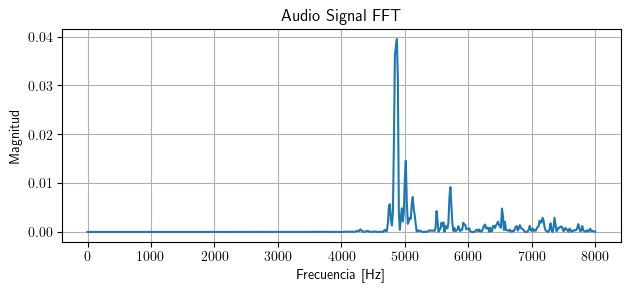

In [218]:
andrew_S=stft(andrew_preemph)
andrew_pow_S = signal_to_power(andrew_S)
test_frame = np.argmax(signals_energy_array(andrew_pow_S))
plot_fft(andrew_pow_S[test_frame], andrew.sr, dtype='freq')

### Prueba de cumplimiento de indentidad de Parseval en la funcion de transformada de Fourier

$$\sum_{n=0}^{N-1}\left | x\left [ n \right ] \right |^{2}= \frac{1}{N}\sum_{k=0}^{N-1}\left | X\left [ k \right ] \right |^{2}$$

Donde:
* $N$ es el tamaño de la secuencia de la señal
* $x\left [ n \right ]$ es la secuencia de la señal
* $X\left [ k \right ]=\mathcal{F}\left \{ x\left [ n \right ] \right \}$ es la transformada de Fourier de la señal tambien de tamaño $N$


In [ ]:
t = np.linspace(0, 1, 8000)
def synth_formant(t, sr, vocal='e'):
    form={#Diccionario de frecuencias de formantes vocales
        'a':[(700, 60), (1500, 200), (2400, 100)],#'vocal':[(F1, sd1), (F2, sd2), (F3, sd3)]
        'e':[(540, 60), (1850, 50), (2540, 140)],#'vocal' es la clave de entrada y hace referencia a la vocal a formar
        'i':[(290, 30), (2200, 180), (2650, 200)],#FN es la frecuencia del formante primero, segundo o tercero
        'o':[(500, 20), (1000, 250), (2280, 100)],#sdN es el desvio que tiene y se usa como ancho de banda para el formante
        'u':[(330, 30), (930, 350), (2300, 100)],#para llamar: form['vocal'][N][F(0) o sd(1)]
    }
    # la onda diente de sierra es mas rica en armonicos que otras formas de onda
    saw = signal.sawtooth(2*np.pi*220*t,width=.8)
    synth_voc=[]# esta es una lista donde almacenamos las tres formantes y luego lo sumamos
    for i, formant in enumerate(form[vocal]):
        fc = form[vocal][i][0]
        # Q es el factor de calidad es igual a fc/bw fc: frecuencia central, bw: ancho de banda
        Q = fc / form[vocal][i][1]
        b, a = signal.iirpeak(fc, Q, sr)
        synth_voc.append(signal.lfilter(b, a, saw))
    synth_voc=np.mean(synth_voc, axis=0)# en realidad lo promediamos para mantener la amplitud
    synth_voc /= np.max(abs(synth_voc)) #deberia sonar como la vocal 'e'
    return synth_voc

In [ ]:
e=synth_formant(t, 8000)
Audio(e, rate=8000)

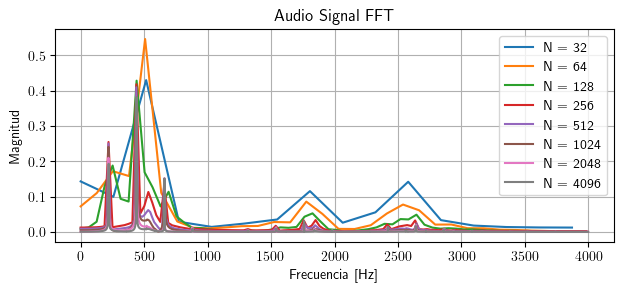

In [ ]:
e32 = e[:31]
e64 = e[:63]
e128 = e[:127]
e256 = e[:255]
e512 = e[:511]
e1024 = e[:1023]
e2048 = e[:2047]
e4096 = e[:4095]
fig, ax = plt.subplots()
ax = plot_fft(e32, 8000, ax=ax, label='N = 32')
ax = plot_fft(e64, 8000, ax=ax, label='N = 64')
ax = plot_fft(e128, 8000, ax=ax, label='N = 128')
ax = plot_fft(e256, 8000, ax=ax, label='N = 256')
ax = plot_fft(e512, 8000, ax=ax, label='N = 512')
ax = plot_fft(e1024, 8000, ax=ax, label='N = 1024')
ax = plot_fft(e2048, 8000, ax=ax, label='N = 2048')
ax = plot_fft(e4096, 8000, ax=ax, label='N = 4096')
plt.show()

In [ ]:
print(np.sum(np.square(e32)), np.sum(np.square(abs(np.fft.fft(e32))))/32)
print(np.sum(np.square(e64)), np.sum(np.square(abs(np.fft.fft(e64))))/64)
print(np.sum(np.square(e128)), np.sum(np.square(abs(np.fft.fft(e128))))/128)
print(np.sum(np.square(e512)), np.sum(np.square(abs(np.fft.fft(e512))))/512)
print(np.sum(np.square(e1024)), np.sum(np.square(abs(np.fft.fft(e1024))))/1024)
print(np.sum(np.square(e2048)), np.sum(np.square(abs(np.fft.fft(e2048))))/2048)

3.8347593051735203 3.7149230768868473
12.852961003647316 12.652133487965324
21.10452810527317 20.93964897945073
73.09114625403627 72.94839010900887
141.8090638576888 141.67057844376524
280.67457891389324 280.537530779658



### Calcular la potencia del espectro

In [ ]:
def spec_show(Sxx, f=None, t=None, ax=None, mfcc=False):
    """
    Muestra un espectrograma en un gráfico.

    Parámetros:
    - Sxx (array): Espectrograma, generalmente una matriz de valores de potencia.
    - f (array, opcional): Vector de frecuencias. Requerido si mfcc=False.
    - t (array, opcional): Vector de tiempos. Requerido si mfcc=False.
    - ax (Matplotlib Axes, opcional): Eje en el que mostrar el espectrograma. Si no se proporciona, se creará uno nuevo.
    - mfcc (bool, opcional): Indica si el espectrograma es de tipo MFCC. Si es True, f y t serán ignorados.

    Retorna:
    - ax (Matplotlib Axes): Eje en el que se muestra el espectrograma.
    - im: Objeto de imagen generado por imshow.

    Recomendaciones:
    - Para espectrogramas MFCC, donde la frecuencia está en Mel y el tiempo en tramas, establecer mel=True.
    - Para espectrogramas normales, proporcionar los vectores f y t.
    - Seleccionar colormaps apropiados para mejorar la interpretación de la información.
    """
    if ax is None:
        fig, ax = plt.subplots()

    if mfcc:
        # Si es un espectrograma de tipo MFCC, la frecuencia está en Mel y el tiempo en trama_i
        im = ax.imshow(Sxx, aspect='auto', cmap='coolwarm', origin='lower')
        ax.set_xlabel('Tiempo [tramas]')
        ax.set_ylabel('$C_x$')
    else:
        # Para otros espectrogramas, se requieren los vectores f y t
        if f is None or t is None:
            raise ValueError("Los vectores f y t son necesarios para espectrogramas.")
        im = ax.imshow(Sxx, aspect='auto', origin='lower', extent=(t[0], t[-1], f[0], f[-1]))
        ax.set_xlabel('Tiempo [segundos]')
        ax.set_ylabel('Frecuencia [Hz]')

    return ax, im


def plotspecgram(s, sr, nfft=1024, hop_len=None, window='hann'):
    """
    Calcula y muestra un espectrograma de potencia logarítmica.

    Parámetros:
    - s (array): Señal de audio.
    - sr (int): Tasa de muestreo de la señal de audio.
    - nfft (int, opcional): Tamaño de la ventana para la transformada de Fourier. Por defecto, 1024.
    - hop_len (int, opcional): Longitud del salto entre ventanas sucesivas. Por defecto, nfft//2.
    - window (str, opcional): Tipo de ventana a aplicar en STFT. Por defecto, 'hann'.

    Retorna:
    - None: La función muestra el espectrograma en una nueva figura.

    Recomendaciones:
    - Ajustar los parámetros nfft y hop_len para lograr el equilibrio adecuado entre resolución temporal y frecuencial.
    - Experimentar con diferentes funciones de ventana para adaptarse a las características de la señal.
    - Utilizar plt.colorbar para interpretar la escala de colores en el espectrograma.
    """
    # Calcular el espectrograma utilizando STFT
    S = stft(s, nfft=nfft, hop_len=hop_len, window=window)
    Sxx = logpowspec(S, nfft=nfft)

    # Calcular las frecuencias y los tiempos correspondientes para el espectrograma
    f = np.linspace(0, sr / 2, S.shape[0])
    t = np.linspace(0, s.size / sr, s.size)

    # Mostrar el espectrograma utilizando spec_show
    fig, ax = plt.subplots()
    ax, im = spec_show(Sxx.T, f, t, ax)
    plt.colorbar(im)
    plt.show()


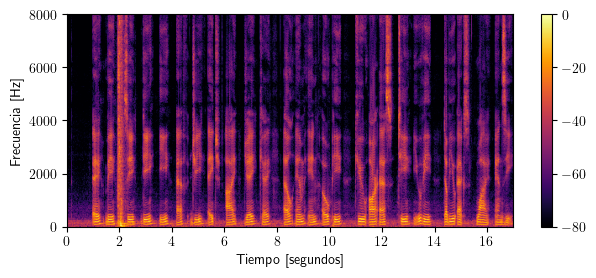

In [146]:
plotspecgram(andrew.s, andrew.sr)

## Banco de filtros en espacio de Mel
Aquí calculamos el banco de filtros Mel-espaciados y luego pasamos el audio enmarcado a través de ellos. Esto nos dará información sobre la potencia en cada banda de frecuencia. Los filtros se pueden construir para cualquier banda de frecuencia, pero para nuestro ejemplo nos fijaremos en toda la banda muestreada.

Lo interesante del banco de filtros espaciado Mel es el espaciado entre los filtros, que crece exponencialmente con la frecuencia. El banco de filtros se puede hacer para cualquier banda de frecuencias. Aquí calcularemos el banco de filtros para toda la banda de frecuencias.

### Cálculo de puntos del filtro

Primero construimos los puntos de filtrado que determinan el inicio y el fin de los filtros. Para ello, primero convertimos los dos bordes del banco de filtros al espacio Mel. Después construimos una matriz lineal entre las dos frecuencias Mel. A continuación, convertimos la matriz al espacio de frecuencias y, por último, normalizamos la matriz al tamaño FFT y elegimos los valores FFT asociados.


In [147]:
def get_filter_points(nfilt=13, nfft=1024, sr=8000, fmin=300, fmax=None):
    """
    Calcula los puntos para un banco de filtros en una escala Mel, dados los
    límites inferior y superior de frecuencia, el número de filtros, el tamaño
    de la FFT y la frecuencia de muestreo.

    Parámetros:
    - nfilt (int, opcional): Número de filtros a crear. Valor por defecto, 13.
    - nfft (int, opcional): Tamaño de la ventana para la transformada rápida de Fourier (FFT). Valor por defecto, 1024.
    - sr (int, opcional): Frecuencia de muestreo en Hz de la señal de audio. Valor por defecto, 8000.
    - fmin (int, opcional): Frecuencia mínima en Hz para el banco de filtros. Valor por defecto, 300.
    - fmax (int, opcional): Frecuencia máxima en Hz para el banco de filtros. Valor por defecto, None.

    Retorna:
    - tuple: Una tupla que contiene dos arrays:
        - filter_points (array): Puntos de filtro en el espectro.
        - freqs (array): Frecuencias correspondientes a los puntos de filtro en Hz.

    Recomendaciones:
    - Ajustar nfilt y nfft según las características de la señal de audio.
    - Experimentar con diferentes valores de fmin y fmax para adaptar el banco de filtros a la señal.
    """
    fmax = fmax or sr/2
    assert fmax <= sr/2, "fmax es mayor que la mitad de la frecuencia de muestreo / 2"
    # calcular puntos con separacion uniforme en mels
    fmin_mel = hz_to_mel(fmin)
    fmax_mel = hz_to_mel(fmax)
    mels = np.linspace(fmin_mel, fmax_mel, num=nfilt+2)
    freqs = mel_to_hz(mels)

    return np.floor((nfft + 1) * freqs / sr ).astype(int)[:], freqs

In [148]:
filter_points, hz_freqs = get_filter_points()
filter_points, hz_freqs

(array([ 38,  53,  70,  88, 109, 132, 159, 188, 220, 256, 297, 342, 393,
        449, 512]),
 array([300.00, 416.88, 547.42, 693.22, 856.07, 1037.94, 1241.07, 1467.95,
        1721.34, 2004.35, 2320.44, 2673.47, 3067.77, 3508.15, 4000.00]))

### Construir el banco de filtros

Después de tener los puntos de filtrado, construimos los filtros.

A continuación dividimos los pesos triangulares Mel por la anchura de la banda Mel (normalización del área). Si no normalizamos los filtros, veremos que el ruido aumenta con la frecuencia debido a la anchura del filtro.

In [149]:
def mel_fbank(filter_points, hz_freqs, nfft=1024, norm=True):
    """
    Calcula un banco de filtros mel.

    Parámetros:
    - filter_points (array): Puntos de filtro en frecuencia.
    - hz_freqs (array): Frecuencias correspondientes a los puntos de filtro en Hz.
    - nfft (int, opcional): Tamaño de la ventana para la transformada de Fourier. Por defecto, 1024.
    - norm (bool, opcional): Normalizar o no los filtros. Por defecto, True.

    Retorna:
    - array: Un banco de filtros mel.

    Recomendaciones:
    - Ajustar nfft según las características de la señal de audio.
    - Experimentar con diferentes valores de norm para adaptar el banco de filtros a la señal.
    """
    filters = np.zeros((len(filter_points) - 2, nfft // 2 + 1))

    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    if norm:
      enorm = 2.0 / (hz_freqs[2:filters.shape[0]+2] - hz_freqs[:filters.shape[0]])#energy normal
      filters *= enorm[:, np.newaxis]
    # Dimensiones de la matriz de salida: (len(filter_points) - 2: número de filtros mel, nfft // 2 + 1: longitud de cada filtro)
    return filters

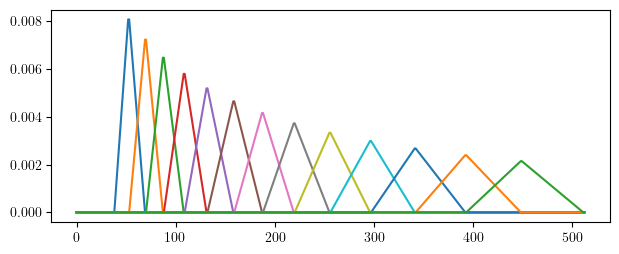

In [163]:
filters = mel_fbank(filter_points, hz_freqs)
for n in range(filters.shape[0]):
    plt.plot(np.arange(filters.shape[1]),filters[n])
plt.show()

### Filtrar la señal

In [219]:
andrew_S_filtered = np.dot(filters, np.transpose(andrew_pow_S))
andrew_coeffs = power_to_db(andrew_S_filtered)
andrew_coeffs

array([[-88.97, -86.52, -87.73, ..., -81.60, -83.37, -88.15],
       [-90.06, -91.06, -89.38, ..., -84.36, -86.23, -91.99],
       [-90.45, -92.00, -88.94, ..., -89.39, -90.60, -94.53],
       ...,
       [-87.77, -90.86, -90.71, ..., -78.79, -88.93, -92.88],
       [-87.62, -90.66, -90.56, ..., -74.81, -86.98, -93.21],
       [-87.61, -89.29, -92.92, ..., -73.32, -83.99, -93.21]])

Ahora tenemos una matriz que representa la potencia de audio en los 13 filtros en diferentes tramas temporales.
## Generar los coeficientes cepstrales
El último paso para generar el MFCC es utilizar la Transformada Discreta del Coseno (DCT). La DCT de tipo 2 asume que la señal de entrada es real y uniforme, como es el caso de la mayoría de las señales de audio. Produce una salida de valor real y se utiliza habitualmente para la extracción de características en aplicaciones de procesamiento del habla y análisis de audio. Por lo tanto, en la mayoría de los casos, para la identificación de locutores y la extracción de características de voz mediante MFCC, la DCT de tipo 2 es la opción adecuada.
### Tipo I
$$y_k = x_0 + (-1)^k x_{N-1} + 2 \sum_{n=1}^{N-2} x_n \cos\left(\frac{\pi k n}{N-1} \right)$$
### Tipo II
$$y_k = 2 \sum_{n=0}^{N-1} x_n \cos\left(\frac{\pi k(2n+1)}{2N} \right)$$
### Tipo III
$$y_k = x_0 + 2 \sum_{n=1}^{N-1} x_n \cos\left(\frac{\pi(2k+1)n}{2N}\right)$$

In [263]:
mfccs = fft.dct(andrew_coeffs, type=2, axis=0, norm='ortho')

In [264]:
mfccs

array([[-323.31, -326.68, -326.39, ..., -282.26, -303.49, -325.93],
       [-2.90, -0.18, 2.47, ..., -10.31, 1.00, 2.68],
       [2.75, 2.10, 1.02, ..., -11.33, -10.80, -7.68],
       ...,
       [0.17, 0.39, 0.04, ..., 2.30, 0.55, 1.09],
       [0.46, 0.48, 0.98, ..., 2.65, 1.21, -0.38],
       [0.46, 0.61, 1.15, ..., 1.03, 0.14, -1.36]])

### Liftering

$$\widehat{MFCC}_n = w_n MFCC_n$$
$$w_n = 1 + \frac{L}{2}\sin{\left ( \frac{\pi n}{L} \right )}$$

In [259]:
def lifter(mfccs, L=12):
    num_ceps, num_frames = mfccs.shape
    # Crear la ventana senoidal para liftering
    n = np.arange(num_ceps)
    lifter_window = 1 + (L / 2) * np.sin(np.pi * n / L)

    # Aplicar liftering a los coeficientes cepstrales
    lifter_mfccs = mfccs * lifter_window[:, np.newaxis]
    return lifter_mfccs, lifter_window

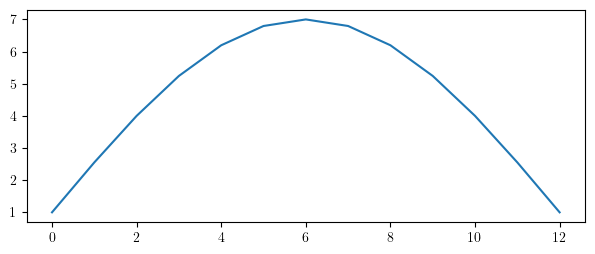

In [265]:
lift_mfccs, lift_window = lifter(mfccs, 12)
plt.plot(lift_window)
plt.show()

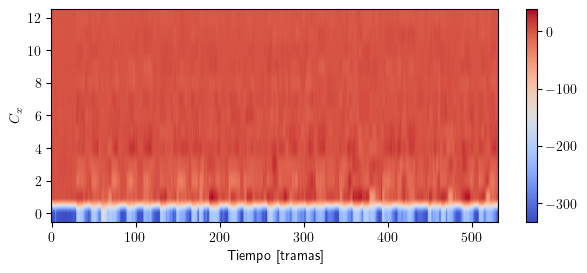

In [266]:
ax, im = spec_show(mfccs,mfcc=True)
plt.colorbar(im)
plt.show()

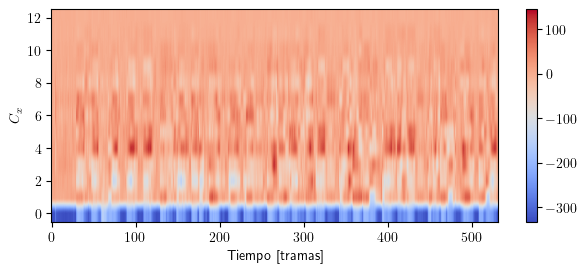

In [267]:
ax, im = spec_show(lift_mfccs,mfcc=True)
plt.colorbar(im)
plt.show()

In [272]:
def mfcc (s, sr,	hop_len=None,	numcep=13,	nfilt=40,	nfft=1024, fmin=300, fmax=None,	lift=0,	winfunc='hann'):
    """
    Calcula los coeficientes cepstrales de frecuencia mel (MFCC) de una señal de audio.

    Parámetros:
    - s (ndarray): La señal de entrada.
    - sr (int): La tasa de muestreo de la señal en Hz.
    - hop_len (int): El tamaño del salto entre tramas en número de muestras.
    - numcep (int): Número de coeficientes cepstrales a calcular.
    - nfilt (int): Número de filtros en el banco de filtros de Mel.
    - nfft (int): Tamaño de la FFT para el cálculo del espectrograma.
    - fmin (int): Frecuencia mínima para el banco de filtros de Mel.
    - fmax (int): Frecuencia máxima para el banco de filtros de Mel. Si no se proporciona, se usa la mitad de la tasa de muestreo.
    - lifter (int): Parámetro de liftering para aplicar a los coeficientes cepstrales. Valor 0 significa no liftering.
    - winfunc (str): Función de ventana a aplicar antes de calcular el espectrograma.

    Retorna:
    - ndarray: Los coeficientes cepstrales de frecuencia mel (MFCC) de la señal.
    """
    s_preemph = preemphasis(s)
    S_stft = stft(s_preemph, nfft=nfft, hop_len=hop_len, window=winfunc)
    pow_S = powspec(S_stft, nfft=nfft)
    fmax = fmax or sr // 2
    filter_points, mel_freqs = get_filter_points(nfilt=nfilt, nfft=nfft, sr=sr, fmin=fmin, fmax=fmax)
    filters = mel_fbank(filter_points, mel_freqs)
    pow_S_filtered = np.dot(filters, np.transpose(pow_S))
    coeffs = power_to_db(pow_S_filtered)
    mfccs = fft.dct(coeffs, type=2, axis=0, norm='ortho')[:numcep]
    if lift != 0:
        lifter_mfccs = lifter(mfccs, lift)
        return lifter_mfccs
    else:
        return mfccs


def cmvn(features):
    """
    Realiza la normalización de media y desviación estándar cepstral.

    Parámetros:
    - features (numpy.ndarray): Matriz de características cepstrales (dimensiones: 13 x n_frames).

    Retorna:
    numpy.ndarray: Matriz de características normalizada.
    """
    # Calcular la media y la desviación estándar cepstral a lo largo de las muestras
    cepstral_mean = np.mean(features, axis=0, keepdims=True)
    cepstral_std = np.std(features, axis=0, keepdims=True)

    # Normalizar las características cepstrales
    normalized_features = (features - cepstral_mean) / cepstral_std

    return normalized_features


def get_features(vs):
    """
    Extrae características MFCC de un objeto VoiceSample.

    Parámetros:
    - vs (VoiceSample): El objeto VoiceSample del cual extraer las características.

    Retorna:
    - ndarray: Características extraídas, concatenando los coeficientes cepstrales de frecuencia mel (MFCC),
              sus derivadas primera y segunda (delta y delta-delta).
    """
    s, sr = vs.s, vs.sr
    s = trim_silence(s, sr)
    # Audio(s, rate=sr)
    mfccs = cmvn(mfcc(s, sr))
    mfcc_delta = delta(mfccs)
    mfcc_delta2 = delta(mfccs, order=2)
    feats = np.concatenate((mfccs, mfcc_delta, mfcc_delta2))
    return feats

In [273]:
mfccs = cmvn(lift_mfccs)
mfcc_delta = delta(mfccs)
mfcc_delta2 = delta(mfccs, order=2)
feats = np.concatenate([mfccs, mfcc_delta, mfcc_delta2], axis=0)

In [274]:
feats

array([[-3.46, -3.46, -3.46, ..., -3.05, -3.25, -3.40],
       [0.19, 0.21, 0.33, ..., -0.07, 0.26, 0.31],
       [0.40, 0.31, 0.30, ..., -0.29, -0.26, -0.11],
       ...,
       [0.01, 0.00, 0.00, ..., 0.01, 0.01, 0.01],
       [0.01, 0.00, -0.00, ..., -0.01, -0.01, 0.00],
       [0.01, 0.01, -0.00, ..., -0.00, -0.00, -0.00]])

In [275]:
feat=get_features(vs_list[0])
feat
#np.shape(feat)

array([[-3.46, -3.46, -3.46, ..., -3.44, -3.44, -3.45],
       [0.29, 0.36, 0.40, ..., 0.48, 0.50, 0.46],
       [0.28, 0.19, 0.19, ..., 0.08, 0.08, 0.12],
       ...,
       [-0.00, -0.00, 0.00, ..., 0.01, 0.01, 0.00],
       [-0.00, -0.00, -0.00, ..., 0.00, 0.00, 0.00],
       [-0.01, -0.01, 0.00, ..., 0.01, 0.00, 0.00]])

### Revisión de coeficientes Cepstrales

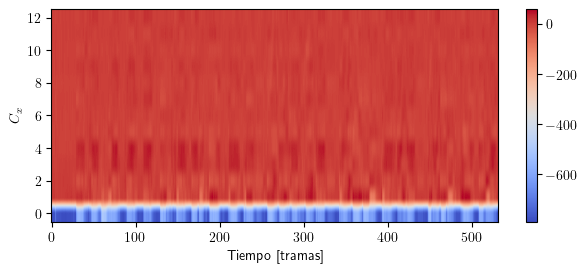

In [276]:
custom_mfcc = mfcc(andrew.s,andrew.sr)
ax, im = spec_show(custom_mfcc, mfcc=True)
#im.set_clim(-350,150)
plt.colorbar(im)
#print(type(im))
#plt.clim(-400,100)
plt.show()

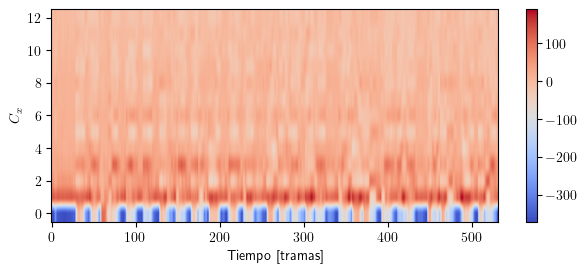

In [277]:
librosa_mfcc = librosa.feature.mfcc(y=(andrew.s*1.0),sr=sr,n_mfcc=13, center=True, pad_mode='constant')
#fig, ax = plt.subplots()
ax, im = spec_show(librosa_mfcc, mfcc=True)
plt.colorbar(im)
plt.show()

In [121]:
(noisy_audio) = additive_noise(andrew.s, andrew.sr)

In [122]:
Audio(noisy_audio[2], rate=andrew.sr)

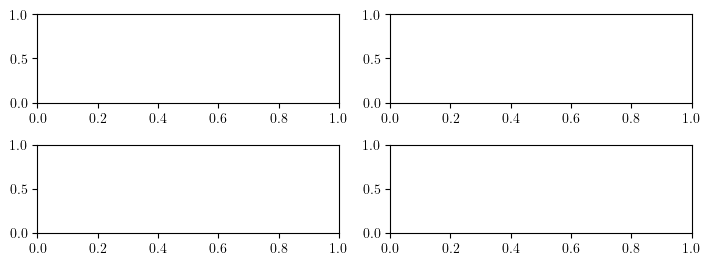

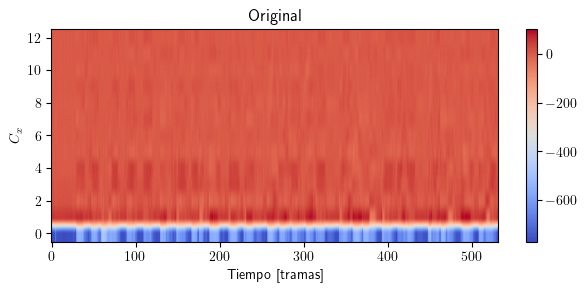

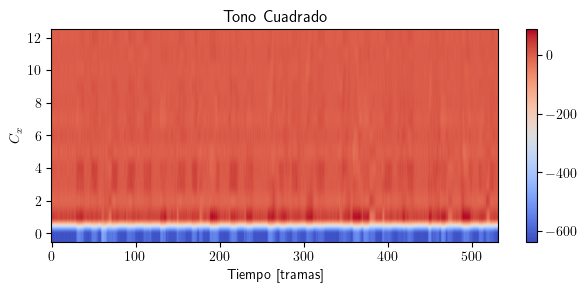

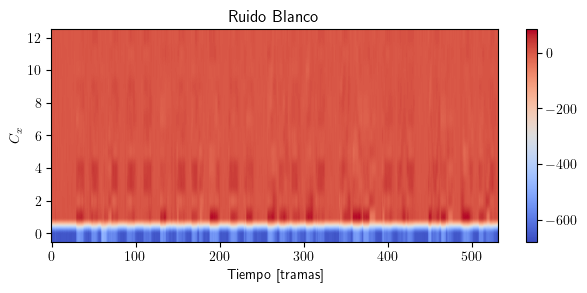

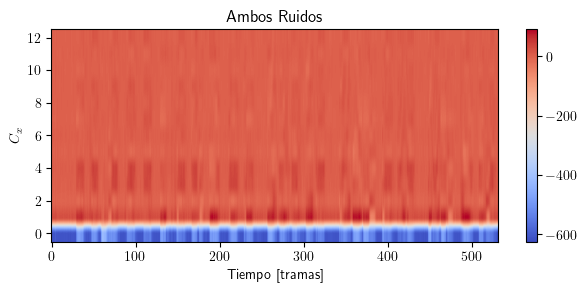

In [123]:
# Crear un subplot 2x2 para comparar los espectrogramas
fig, axs = plt.subplots(2, 2, layout='tight')

# Espectrograma del audio original
axs[0, 0], im = spec_show(mfccs, mfcc=True)
axs[0, 0].set_title("Original")
fig.colorbar(im, ax=axs[0, 0])

# Espectrograma del tono cuadrado
square_noisy_mfcc = mfcc(noisy_audio[0], sr)
axs[0, 1], im = spec_show(square_noisy_mfcc, mfcc=True)
axs[0, 1].set_title("Tono Cuadrado")
fig.colorbar(im, ax=axs[0, 1])

# Espectrograma del ruido blanco
white_noisy_mfcc = mfcc(noisy_audio[1], sr)
axs[1, 0], im = spec_show(white_noisy_mfcc, mfcc=True)
axs[1, 0].set_title("Ruido Blanco")
fig.colorbar(im, ax=axs[1, 0])

# Espectrograma de la mezcla de tono cuadrado y ruido blanco
noisy_mfcc = mfcc(noisy_audio[2], sr)
axs[1, 1], im = spec_show(noisy_mfcc, mfcc=True)
axs[1, 1].set_title("Ambos Ruidos")
fig.colorbar(im, ax=axs[1, 1])

plt.show()

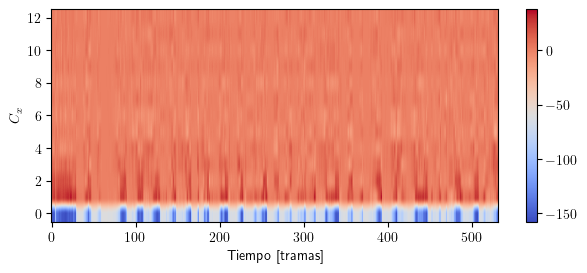

In [124]:
mfccs = mfcc(andrew.s,andrew.sr)
diff = mfccs - noisy_mfcc
ax, im = spec_show(diff, mfcc=True)
plt.colorbar(im)
plt.show()

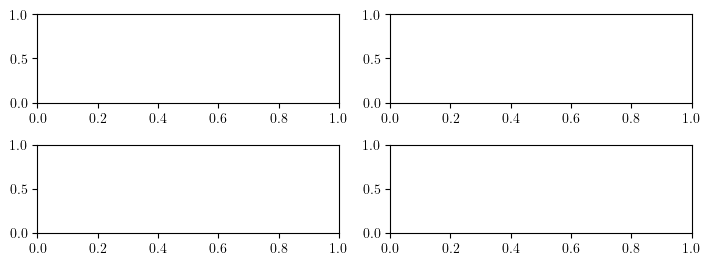

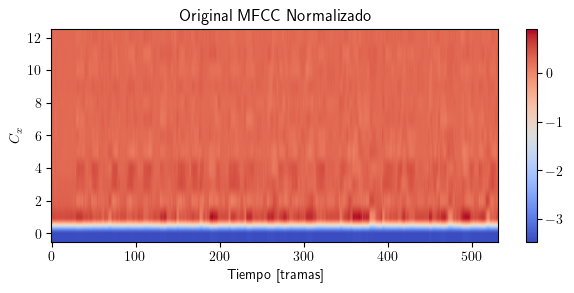

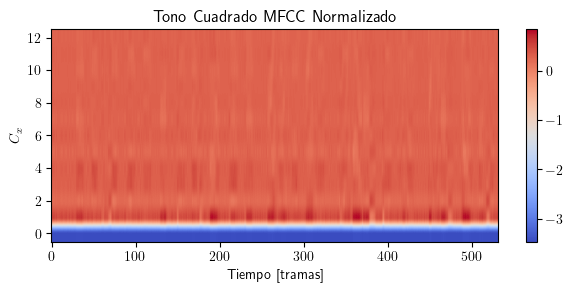

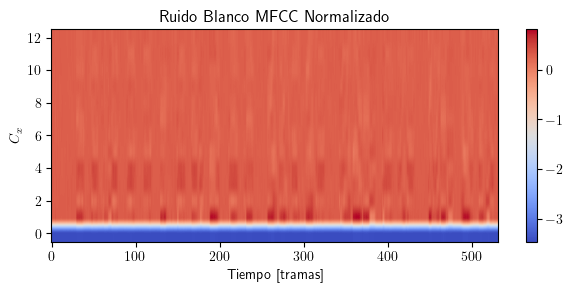

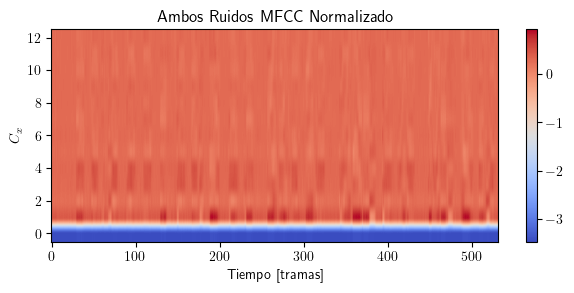

In [125]:
# Crear un subplot 2x2 para comparar los espectrogramas
fig, axs = plt.subplots(2, 2, layout='tight')

# Espectrograma del audio original
norm_mfccs = cmvn(mfccs)
axs[0, 0], pcm = spec_show(norm_mfccs, mfcc=True)
axs[0, 0].set_title("Original MFCC Normalizado")
fig.colorbar(pcm, ax=axs[0, 0])

# Espectrograma del tono cuadrado
norm_square_noisy_mfcc = cmvn(square_noisy_mfcc)
axs[0, 1], pcm = spec_show(norm_square_noisy_mfcc, mfcc=True)
axs[0, 1].set_title("Tono Cuadrado MFCC Normalizado")
fig.colorbar(pcm, ax=axs[0, 1])

# Espectrograma del ruido blanco
norm_white_noisy_mfcc = cmvn(white_noisy_mfcc)
axs[1, 0], pcm = spec_show(norm_white_noisy_mfcc, mfcc=True)
axs[1, 0].set_title("Ruido Blanco MFCC Normalizado")
fig.colorbar(pcm, ax=axs[1, 0])

# Espectrograma de la mezcla de tono cuadrado y ruido blanco
norm_noisy_mfcc = cmvn(noisy_mfcc)
axs[1, 1], pcm = spec_show(norm_noisy_mfcc, mfcc=True)
axs[1, 1].set_title("Ambos Ruidos MFCC Normalizado")
fig.colorbar(pcm, ax=axs[1, 1])

plt.show()

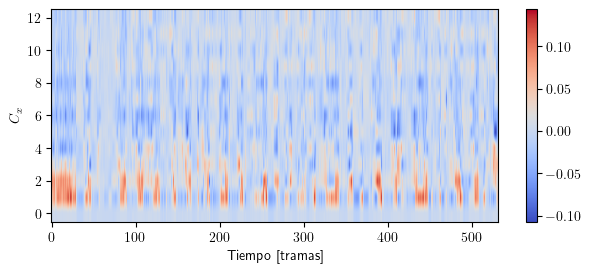

In [126]:
diff = norm_mfccs - norm_noisy_mfcc
ax, im = spec_show(diff, mfcc=True)
plt.colorbar(im)
plt.show()

## Modelo de mezcla gaussiana

![](https://drive.google.com/uc?export=view&id=1FZiMoTnSj5V5nt_BCIDKajLs4LdhvVYE)
El núcleo de la decisión de verificación del hablante es la relación de probabilidad. Digamos que queremos determinar si la muestra de voz Y (del conjunto de verificación) fue hablada por S.

Entonces, la tarea de verificación es una prueba de hipótesis básica:

$H_{0}$: Y es el hablante S, $H_{1}$: Y __NO__ es el hablante S.

La prueba para decidir si aceptar $H_{0}$ o no es la razón de verosimilitud (LR):

$$LR = \frac{p(Y \mid H_0)}{p(Y \mid H_1)}$$

Si la razón de probabilidad es mayor que el umbral $\theta$, aceptamos $H_{0}$, de lo contrario aceptamos $H_{1}$.

Si hablamos en términos de logaritmos, entonces la razón de verosimilitud logarítmica es simplemente la diferencia entre los logaritmos de las 2 funciones de densidad de probabilidad:

$$\log(LR) = \log(p(Y \mid H_0)) - \log(p(Y \mid H_1))$$

Tenemos un hablante para probar $H_{0}$, y podemos construir un modelo, digamos $\lambda_{hyp}$, siendo por ejemplo una Distribución Gaussiana de las características extraídas.

Sin embargo, no tenemos un modelo alternativo para $H_{1}$. Debemos calcular lo que se llama un “Modelo de Fondo”, que sería un Modelo Gaussiano $\lambda_{\overline{hyp}}$.

Hay 2 opciones para el modelo de fondo:

* Considere el conjunto cerrado de otros hablantes y
calcule:
$p(X \mid \lambda_{\overline{hyp}}) = f ( p(X \mid \lambda_1), ..., p(X \mid \lambda_N))$
, dónde ***f*** es una función agregativa como la media o el máximo. Sin embargo, requiere un modelo por hipótesis alternativa, es decir, por hablante.
* o considere un grupo de varios oradores diferentes para entrenar un solo modelo, llamado Modelo de fondo universal (UBM)

La principal ventaja del UBM es que es universal en el sentido de que puede ser utilizado por cualquiera de los hablantes, sin tener que volver a entrenar un modelo.

## Modelo universal de fondo
Un UBM es un modelo de mezcla gaussiana de alto orden (generalmente de 512 a 2048 mezclas con 24 dimensionesa) entrenado en una gran cantidad de habla, de una amplia población. Este paso se usa para aprender la distribución de características independiente del hablante, que se usa en la hipótesis alternativa en la razón de verosimilitud.

Para un vector de características D-dimensional $x$, la densidad de la mezcla es:

$$P(x \mid \lambda) = \sum_{k=1}^M w_k \times g(x \mid \mu_k, \Sigma_k)$$

Dónde:

* $x$ es un vector de características D-dimensional
* $w_k, k = 1, 2, ..., M$ es la mezcla pesos st suman 1
* $\mu_k, k = 1, 2, ..., M$ es la media de cada gaussiana
* $\Sigma_k, k = 1, 2, ..., M$ es la covarianza de cada gaussiana
* $g(x \mid \mu_k, \Sigma_k)$ son las densidades gaussianas tales que:
$$g(x \mid \mu_k, \Sigma_k) = \frac{1}{(2 \pi)^{\frac{D}{2}} {\mid \Sigma_k \mid}^{\frac{1}{2}}} exp^{ - \frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x-\mu_k)}$$

Los parámetros del GMM son por lo tanto:$\lambda = (w_k, \mu_k, \Sigma_k), k = 1, 2, 3, ..., M$

Por lo general, usamos una matriz de covarianza diagonal en lugar de una de covarianza completa, ya que es más eficiente desde el punto de vista computacional y empíricamente funciona mejor.

El GMM se entrena en una colección de vectores de entrenamiento. Los parámetros del GMM se calculan iterativamente utilizando el algoritmo Expectation-Maximization (EM) y, por lo tanto, no hay garantías de que se convierta dos veces en la misma solución dependiendo de la inicialización.

Bajo el supuesto de vectores de características independientes, la probabilidad logarítmica de un modelo
$\lambda$
para una secuencia
$X = (x_1, x_2, ..., x_T)$
es simplemente el promedio de todos los vectores de características:

$$\log p(X \mid \lambda) = \frac{1}{T} \sum_t \log p(x_t \mid \lambda)$$

##Inscripcion de oradores

El último paso antes de la verificación es realizar el alta del altavoz. El objetivo sigue siendo entrenar también un modelo de mezcla gaussiana en las características extraídas para cada altavoz, lo que da como resultado 20 modelos si tenemos 20 hablantes.

Hay 2 enfoques para modelar los hablantes:

* entrenar un GMM de menor dimensión (64 a 256 mezclas) dependiendo de la cantidad de datos de inscripción que tengamos
* adaptar el UBM GMM al modelo de hablante utilizando la Adaptación Máxima a Posterior (MAP), generalmente el enfoque seleccionado

En MAP, simplemente iniciamos el algoritmo EM con los parámetros aprendidos por el UBM. Mediante este paso, solo adaptamos la media, y no la covarianza, ya que actualizar la covarianza no mejora el rendimiento.

Para que la media se actualice, realizamos una adaptación máxima a posteriori:

$$\mu_k^{MAP} = \alpha_k \mu_k + (1 - \alpha_k) \mu_k^{UBM}$$

Dónde :

* $\alpha_k = \frac{n_k}{n_k + \tau_k}$
es el coeficiente de adaptación medio
* $n_k$
es el recuento de los datos de adaptación
* $\tau_k$
es el factor de relevancia, entre 8 y 32

## Verificacion del orador
Para una muestra en la carpeta de prueba, calculamos la puntuación de la GMM de identidad reclamada en el conjunto de inscripción. Restamos la puntuación del GMM de la UBM para cada uno y obtenemos la razón de verosimilitud. Luego comparamos el puntaje con nuestro umbral (generalmente 0) y aceptamos o rechazamos la identidad del hablante.

### Funciones de entrenamiento para el modelo de mezcla gaussiana

In [ ]:
def load_audio_extract_features(audio_path):
    feats_list = []
    vs_list = []
    names_list = []

    for filename in sorted(glob.glob(os.path.join(audio_path, '*.wav'))):
        name = os.path.splitext(os.path.basename(filename))[0]
        y, sr = load_audio(filename, new_sr=16000)
        this_vs = VoiceSample(y, sr, name)
        vs_list.append(this_vs)
        feats = get_features(this_vs)
        feats_list.append(feats)
        names_list.append(name)

    data = dict(zip(names_list, feats_list))
    return data

def train_models(data, ubm_params=None, speaker_models_params=None):
    features_train = np.hstack(list(data.values())).T
    speaker_names = list(data.keys())

    # Entrenamiento del modelo UBM
    ubm_params = ubm_params or {
        'n_components': 64,
        'covariance_type': 'diag',
        'n_init': 3,
        'max_iter': 100,
        'random_state': 0
    }
    ubm = GMM(**ubm_params)
    ubm.fit(features_train)

    # Entrenamiento de modelos GMM específicos para cada locutor
    speaker_models = {}
    default_speaker_model_params = {
        'n_components': 8,
        'covariance_type': 'diag',
        'n_init': 3,
        'max_iter': 100,
        'random_state': 0
    }
    speaker_models_params = speaker_models_params or {}
    for speaker in speaker_names:
        speaker_data = data[speaker]
        try:
            speaker_model_param = speaker_models_params[speaker]
        except KeyError:
            speaker_model_param = default_speaker_model_params

        speaker_model = GMM(**speaker_model_param)
        speaker_model.fit(speaker_data)
        speaker_models[speaker] = speaker_model

    return ubm, speaker_models

In [ ]:
# Paso 1: Preparación de los datos
data = load_audio_extract_features(AUDIOPATH) # Diccionario con los coeficientes MFCC para cada locutor

ubm, speaker_models = train_models(data)

In [ ]:
features = np.hstack(list(data.values())).T  # Apilar los coeficientes MFCC en una matriz

def gmm_bic_score(estimator, X):
    """
    Puntuación BIC para utilizar como función llamable en GridSearchCV.

    Parámetros:
    - estimador (GaussianMixture): El modelo de mezcla gaussiana ya ajustado.
    - X (array-like): Datos de entrada.

    Retorna:
    - float: Puntuación BIC del modelo en los datos proporcionados. Se devuelve negativa,
             ya que GridSearchCV espera una puntuación para maximizar.
    """
    # Se hace negativa ya que GridSearchCV espera una puntuación para maximizar
    return -estimator.bic(X)


param_grid = {
    'n_components': [4, 8, 16],
    'covariance_type': ['tied', 'diag'],
}
grid_search = GridSearchCV(
    GMM(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(features)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['tied', 'diag'],
                         'n_components': [4, 8, 16]},
             scoring=<function gmm_bic_score at 0x7b2e740168c0>)

In [ ]:
df = pd.DataFrame(grid_search.cv_results_)[
    ['param_n_components', 'param_covariance_type', 'mean_test_score']
]
df['mean_test_score'] = -df['mean_test_score']
df = df.rename(
    columns={
        'param_n_components': "Number of components",
        'param_covariance_type': "Type of covariance",
        'mean_test_score': "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance      BIC score
0                    4               tied -109113.253578
1                    8               tied -108396.829575
2                   16               tied -106009.189198
3                    4               diag -104315.540088
4                    8               diag -103366.061616

In [ ]:
# Grid de hiperparámetros para el modelo UBM
ubm_params = {
    'n_components': [4, 8, 16],
    'covariance_type': ['diag', 'tied'],
}

def eval_valid_ubm(features_train, ubm_params):
    """Optimiza y valida modelos GMM para cada locutor en un conjunto de datos.

    Parámetros:
        speaker_models (dict): Un diccionario que contiene modelos GMM iniciales para cada locutor.
            Las claves son los nombres de los locutores y los valores son modelos GMM.
        data (dict): Un diccionario que contiene datos de entrenamiento para cada locutor.
            Las claves son los nombres de los locutores y los valores son matrices de características.
        gmm_params (dict): Parámetros de la búsqueda de cuadrícula para optimizar los modelos GMM.
        gmm_bic_score (callable): Función que calcula el puntaje BIC para un modelo GMM.

    Retorna:
        tuple: Una tupla que contiene los mejores modelos y sus puntajes.
            - best_models (dict): Un diccionario que contiene los mejores modelos para cada locutor.
                Las claves son los nombres de los locutores y los valores son los mejores modelos GMM.
            - best_scores (dict): Un diccionario que contiene los puntajes BIC de los mejores modelos para cada locutor.
                Las claves son los nombres de los locutores y los valores son los puntajes BIC.

    Ejemplo:
        best_models, best_scores = optimize_and_validate_speaker_models(speaker_models, data, gmm_params, gmm_bic_score)

    Esta función realiza una búsqueda de cuadrícula para encontrar los mejores hiperparámetros
    para los modelos GMM de cada locutor. Luego, utiliza validación cruzada para evaluar
    el rendimiento de los modelos y devuelve los mejores modelos junto con sus puntajes BIC.

    """
    # Búsqueda de hiperparámetros óptimos para el modelo UBM
    ubm_gridsearch = GridSearchCV(GMM(), ubm_params, scoring=gmm_bic_score, cv=5, verbose=2)
    ubm_gridsearch.fit(features_train)

    # Obtener los mejores hiperparámetros y puntajes
    best_ubm_params = ubm_gridsearch.best_params_
    best_ubm_score = -ubm_gridsearch.best_score_

    print("Mejores hiperparámetros para el modelo UBM:", best_ubm_params)
    print("Puntaje del modelo UBM: {:.2f}".format(best_ubm_score))

    # Validación cruzada con el mejor modelo UBM
    best_ubm_model = GMM(**best_ubm_params)
    # Validación cruzada con 5 pliegues
    ubm_cv_scores = cross_val_score(best_ubm_model, features, cv=5, verbose=2)
    ubm_accuracy = np.mean(ubm_cv_scores)
    print("Precisión promedio del modelo UBM: {:.2f}".format(ubm_accuracy))

    return best_ubm_model, best_ubm_params

best_ubm_model, best_ubm_params = eval_valid_ubm(features, ubm_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.2s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.0s
[CV] END ...............covariance_type=diag, n_components=8; total time=   0.2s
[CV] END ...............covariance_type=diag, n_components=8; total time=   0.2s
[CV] END ...............covariance_type=diag, n_components=8; total time=   0.2s
[CV] END ...............covariance_type=diag, n_components=8; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=8; total time=   0.2s
[CV] END ..............covariance_type=diag, n_components=16; total time=   0.4s
[CV] END ..............covariance_type=diag, n_co

In [ ]:
# Grid de hiperparámetros para el modelo GMM de clasificación
speakers_models_params = {
    'n_components': [4, 8, 16],
    'covariance_type': ['diag', 'tied'],
}

def eval_valid_speakers_models(speaker_models, data, gmm_params, scoring_function):
    """Optimiza y valida modelos GMM para cada locutor en un conjunto de datos.

    Esta función realiza una búsqueda de cuadrícula para optimizar los hiperparámetros de los modelos GMM
    para cada locutor en el conjunto de datos proporcionado. Luego, valida los modelos utilizando
    validación cruzada y devuelve los mejores modelos y sus puntajes.

    Parámetros:
        speaker_models (dict): Un diccionario que contiene modelos GMM iniciales para cada locutor.
            Las claves son los nombres de los locutores y los valores son modelos GMM.
        data (dict): Un diccionario que contiene datos de entrenamiento para cada locutor.
            Las claves son los nombres de los locutores y los valores son matrices de características.
        speakers_models_params (dict): Parámetros de la búsqueda de cuadrícula para optimizar los modelos GMM.
        gmm_bic_score (callable): Función que calcula el puntaje BIC para un modelo GMM.

    Retorna:
        tuple: Una tupla que contiene los mejores modelos y sus puntajes.
            - best_models (dict): Un diccionario que contiene los mejores modelos para cada locutor.
                Las claves son los nombres de los locutores y los valores son los mejores modelos GMM.
            - best_scores (dict): Un diccionario que contiene los puntajes BIC de los mejores modelos para cada locutor.
                Las claves son los nombres de los locutores y los valores son los puntajes BIC.

    Ejemplo:
        best_models, best_scores = train_speaker_models_evaluate(speaker_models, data, gmm_params, gmm_bic_score)
    """
    best_models = {}
    best_params = {}
    best_scores = {}

    for speaker, speaker_model in speaker_models.items():
        gridsearch = GridSearchCV(speaker_model, gmm_params, scoring=scoring_function, cv=5, verbose=1)
        gridsearch.fit(data[speaker])
        best_model = gridsearch.best_estimator_
        best_param = gridsearch.best_params_
        best_score = -gridsearch.best_score_
        best_models[speaker] = best_model
        best_params[speaker] = best_param
        best_scores[speaker] = best_score

        print("Mejores hiperparámetros para el modelo de", speaker)
        print(best_param)
        print("Mejor puntaje:", best_score)
        print()
        # Entrenamiento y validación del modelo GMM de clasificación
        # Validación cruzada para el modelo específico
        cv_scores = cross_val_score(best_model, data[speaker], cv=5, verbose=1)
        cv_accuracy = np.mean(cv_scores)
        print("Validación cruzada para el modelo de", speaker)
        print("Puntaje promedio de validación cruzada:", cv_accuracy)
        print()

    return best_models, best_params

best_speakers_models, best_speakers_params = eval_valid_speakers_models(speaker_models, data, speakers_models_params, gmm_bic_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para el modelo de Joaquin
{'covariance_type': 'diag', 'n_components': 4}
Mejor puntaje: 2163749.116427839

Validación cruzada para el modelo de Joaquin
Puntaje promedio de validación cruzada: -134755.57567274664

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para el modelo de Marta A
{'covariance_type': 'diag', 'n_components': 4}
Mejor puntaje: 13845507.787048822

Validación cruzada para el modelo de Marta A
Puntaje promedio de validación cruzada: -864889.3364022418

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para el modelo de andrew
{'covariance_type': 'diag', 'n_components': 4}
Mejor puntaje: 14589188.678819532

Validación cruzada para el modelo de andrew
Puntaje promedio de validación cruzada: -911376.8768866479

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para el modelo de arun
{'co

### Pruebas de hipotesis

In [ ]:
def adjust_dimensions(features_test, n_features):
    """
    Ajusta las dimensiones del vector de características para que coincidan con el vector de referencia.

    Parámetros:
    - features_test (numpy.ndarray): Vector de características que se ajustará.
    - reference_features (numpy.ndarray): Vector de referencia que determina la dimensión deseada.

    Retorna:
    - numpy.ndarray: Vector de características ajustado.
    """
    # Si la dimensión de features_test es mayor, recorta los elementos sobrantes
    if features_test.shape[1] > n_features:
        return features_test[:, :n_features]
    # Si la dimensión de features_test es menor, rellena con padding en refleccion
    elif features_test.shape[1] < n_features:
        padding_length = n_features - features_test.shape[1]
        left_padding = padding_length // 2
        right_padding = padding_length - left_padding

        # Reflejar los elementos alrededor del borde para rellenar
        reflected_features = np.pad(features_test, (left_padding, right_padding), mode='reflect')
        return reflected_features
    # Si features_test.shape[1] == n_features, no se realiza ningún ajuste
    else:
        return features_test

In [ ]:
# Paso 4: Prueba de verificación de identidad
def verifica(claimed_id, features_test, ubm, speaker_models, threshold=189_500):
    """
    Realiza la prueba de verificación de identidad utilizando un modelo GMM (Gaussian Mixture Model).

    Parámetros:
    - claimed_id (str, opcional): Identidad reclamada por el locutor de la grabación actual. Si no se proporciona,
      se solicita al usuario que ingrese una identidad registrada.
    - features_test (array): Características del habla del locutor de la grabación actual.
    - threshold (float, opcional): Umbral de probabilidad para la toma de decisión. Por defecto, se establece en 0.7.

    Retorna:
    bool: True si la identidad reclamada es aceptada, False si es rechazada.
    """
    claimed_id = claimed_id or input("Ingrese la identidad reclamada: ")# Identidad reclamada por el locutor de la grabación actual
    speaker_names = list(speaker_models.keys())

    while claimed_id not in speaker_names:
        print("La identidad reclamada no está registrada.")
        print("Identidades registradas:", ", ".join(speaker_names))
        claimed_id= input("Ingrese una identidad registrada: ")
    # Obtener el índice del locutor de la grabación actual
    claimed_model = speaker_models.get(claimed_id)
    # Calcular la probabilidad de que las características sean generadas por el modelo GMM del locutor
    claimed_model_features_test = adjust_dimensions(features_test, claimed_model.n_features_in_)
    log_likelihood_claimed = claimed_model.score(claimed_model_features_test)
    # Calcular la probabilidad de que las características sean generadas por el modelo de fondo UBM
    ubm_features_test = adjust_dimensions(features_test, ubm.n_features_in_)
    log_likelihood_ubm = ubm.score(ubm_features_test)
    # Calcular la probabilidad de que las características pertenezcan al locutor
    likelihood_ratio = log_likelihood_claimed - log_likelihood_ubm
    print("Log Likelihood Ratio:", likelihood_ratio)
    # Tomar la decisión de aceptar o rechazar basado en un umbral
    result = likelihood_ratio >= threshold
    if result:
        print("Verificación exitosa: la identidad reclamada es aceptada.")
    else:
        print("Verificación fallida: la identidad reclamada es rechazada.")
    return result

In [ ]:
# Prueba de identificación
def identifica(features_test, ubm, speaker_models, threshold=189_500):
    """
    Realiza la prueba de identificación del hablante utilizando modelos GMM (Gaussian Mixture Model).

    Parámetros:
    - features_test (array): Características del habla del locutor a identificar.
    - threshold (float, opcional): Umbral de probabilidad para la toma de decisión. Por defecto, se establece en 0.5.

    Retorna:
    str or None: El nombre del hablante identificado o None si no se identifica a ningún hablante.
    """
    ubm_features_test = adjust_dimensions(features_test, ubm.n_features_in_)
    log_likelihood_ubm = ubm.score(ubm_features_test)

    likelihood_ratios = {}
    results = {}
    for speaker, speaker_model in speaker_models.items():
        speaker_features_test = adjust_dimensions(features_test, speaker_model.n_features_in_)
        log_likelihood_speaker = speaker_model.score(speaker_features_test)
        likelihood_ratio = log_likelihood_speaker - log_likelihood_ubm
        likelihood_ratios[speaker] = likelihood_ratio
        results[speaker] = likelihood_ratio

    #max_log_likelihood = max(likelihood_ratios.values())
    # Crear un DataFrame de pandas para mostrar los resultados ordenados por log likelihood
    df_results = pd.DataFrame(list(results.items()), columns=['Speaker', 'Log Likelihood Ratio'])
    df_results = df_results.sort_values(by='Log Likelihood Ratio', ascending=False)

    print("Tabla de Modelos Comparados:")
    print(df_results)

    max_log_likelihood = df_results.iloc[0]['Log Likelihood Ratio']
    identified_speaker = df_results.iloc[0]['Speaker']

    identified_speaker = None

    if max_log_likelihood >= threshold:
        identified_speaker = max(likelihood_ratios, key=likelihood_ratios.get)
        print("Resultado de identificación:", identified_speaker)
    if identified_speaker is None:
        print("Hablante desconocido")
    return identified_speaker

## Menu Principal

In [ ]:
# Clase menu principal

class Menu:
    """
    Clase que representa un menú con un título, una descripción y opciones.

    Atributos:
        title (str): El título del menú.
        description (str): Una descripción breve del menú.
        options (dict): Un diccionario que contiene las opciones del menú.
            Las claves son números enteros que representan el número de opción, y los valores son
            cadenas de caracteres que describen la acción asociada a la opción.

    Métodos:
        show_menu(): Muestra el menú en la consola, incluyendo el título, la descripción y las opciones.
        get_user_choice(): Solicita al usuario que ingrese un número de opción, lo valida y lo devuelve.

    Ejemplo:
        menu = Menu("Menú principal", "Bienvenido al menú principal", {1: "Opción 1", 2: "Opción 2"})
        menu.show_menu()
        choice = menu.get_user_choice()
        # Realizar alguna acción basada en la elección del usuario
    """
    def __init__(self, title, description, options):
        self.title = title
        self.description = description
        self.options = options

    def show_menu(self):
        """Muestra el menú en la consola, incluyendo el título, la descripción y las opciones."""
        print(self.title)
        print(self.description)
        for key, value in self.options.items():
          print(f"{key}. {value}")

    def usr_choice(self):
        """Solicita al usuario que ingrese un número de opción, lo valida y lo devuelve.

        Returns:
            int: El número de opción ingresado por el usuario.

        Raises:
            ValueError: si lo ingresado por el usuario no se puede castear a entero.

        Ejemplo:
            choice = get_user_choice()
            # Realizar alguna acción basada en la elección del usuario
        """
        while True:
          user_input = input("¿Que quiere hacer?: ")
          try:
            choice = int(user_input)
            if choice in self.options:
              return choice
            else:
              print("Ingreso opcion no en lista, intente de nuevo.")
          except ValueError:
              print("ingreso invalido, ingrese una opcion valida en la lista.")


options = {
    1: "Listar nombres",
    2: "Registrar nuevo usuario",
    3: "Prueba de verificacion",
    4: "Prueba de identifiacion",
    0: "Salir",
    }


while True:
    main_menu = Menu(
        "Menu Principal",
        "Bienvenido al proyecto de reconocimiento del hablante MFCC-GMM.",
        options
        )
    main_menu.show_menu()
    choice = main_menu.usr_choice()
    if choice == 1:
        list_reg_names(file_list)
    elif choice == 2:
        add_reg_audio(local_download_path)
        data = load_audio_extract_features(AUDIOPATH)
        features = np.hstack(list(data.values())).T  # Apilar los coeficientes MFCC en una matriz
        best_ubm_model, best_ubm_params = eval_valid_ubm(features, ubm_params)
        best_speakers_models, best_speakers_params = eval_valid_speakers_models(speaker_models, data, speakers_models_params, gmm_bic_score)
        ubm, speaker_models = train_models(data, best_ubm_params, best_speakers_params)
    elif choice == 3:
        claimed_id = input("Ingrese la identidad reclamada: ")
        vs = add_reg_audio(local_download_path)
        vs.resample(16000)
        features_test = get_features(vs)
        verifica(claimed_id, features_test, ubm, speaker_models)
    elif choice == 4:
        vs = add_reg_audio(local_download_path)
        vs.resample(16000)
        feats = get_features(vs)
        identifica(feats, ubm, speaker_models)
    elif choice == 0:
        break
    else:
        print("Opción inválida. Por favor ingrese una opción válida.")

Menu Principal
Bienvenido al proyecto de reconocimiento del hablante MFCC-GMM.
1. Listar nombres
2. Registrar nuevo usuario
3. Prueba de verificacion
4. Prueba de identifiacion
0. Salir
¿Que quiere hacer?: 0


In [ ]:
rocio_s, _ = load_audio("/content/rocio_test.wav", 16000)
rocio = VoiceSample(rocio_s, 16000, "rocio")
rocio_test_feats = get_features(rocio)
result = identifica(rocio_test_feats, ubm, speaker_models)

In [ ]:
enzo_s, _ = load_audio("/content/enzo_test.wav", 16000)
enzo = VoiceSample(enzo_s, 16000, "enzo")
enzo_test_feats = get_features(enzo)
result = identifica(enzo_test_feats, ubm, speaker_models)

##Conclusiones

Usos del proyecto de reconocimiento del hablante:
1. Seguridad biométrica: El reconocimiento del hablante puede utilizarse como una medida adicional de seguridad en sistemas de autenticación biométrica, como en el desbloqueo de dispositivos o el acceso a sistemas protegidos.
2. Verificación de identidad: El sistema de reconocimiento del hablante puede utilizarse para verificar la identidad de una persona en aplicaciones donde la autenticación precisa es crucial, como en instituciones financieras o gubernamentales.
3. Investigación forense: El reconocimiento del hablante puede ser utilizado en investigaciones forenses para analizar y comparar grabaciones de audio con el fin de identificar a una persona involucrada en un delito o verificar la autenticidad de una grabación.
4. Asistentes de voz personalizados: El reconocimiento del hablante puede ayudar a desarrollar asistentes de voz personalizados que reconocen a los usuarios y adaptan su comportamiento y respuestas según las preferencias y características de cada hablante.

Deducciones y conclusiones del procesamiento de señales aplicado al proyecto:
1. El procesamiento de señales utilizando técnicas como MFCC (coeficientes cepstrales de frecuencia mel) permite extraer características relevantes de la señal de voz y representarlas de manera compacta y discriminativa para el reconocimiento del hablante.
2. El ventaneo de la señal de voz en segmentos temporales más pequeños permite analizar características locales y capturar variaciones en la señal a lo largo del tiempo.
3. El espectrograma, derivado del ventaneo y la transformada de Fourier, proporciona una representación visual del contenido espectral de la señal de voz, lo que facilita el análisis de las características de frecuencia en diferentes momentos.
4. El reconocimiento del hablante basado en el procesamiento de señales se beneficia de algoritmos de aprendizaje automático, como los modelos de mezcla gaussiana, que pueden capturar y modelar las variaciones estadísticas de los patrones de voz de diferentes hablantes.
5. La precisión y robustez del reconocimiento del hablante pueden mejorarse mediante la selección de parámetros óptimos, como el número de componentes de la mezcla y el tipo de covarianza, utilizando técnicas como validación cruzada y ajuste de hiperparámetros.

La mejora del sistema de reconocimiento ahora se basa en ajustar la combinacion de parametros como la frecuencia de muestreo reducida, la funcion de ventana, el tamaño de ventana, y los parametros de modelo de mezcla gaussiana a fin de conseguir la mejor puntuacion de discriminacion y realizar pruebas de hipotesis con mas confianza.

##Referencias bibliograficas
Oppenheim A., Schafer R.(1998). *Discrete -time Signal Processing. Second edition*. Prentice-Hall

Oppenheim A., Willsky A.(1998). *Señales y Sistemas. Segunda edicion*. Prentice-Hall

Camplbell J. P.(1999). *Speaker Recognition: A Tutorial.* IEEE

Espinosa Cuadros F. M.(2012). *Identificacion de hablantes a partir de trayectorias temporales en unidades lingüísticas sobre grandes bases de datos*. Universidad Politécnica de Madrid

ILM. *MFCC implementation and tutorial*. Kaggle https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial

Desconocido. *Mel Frequency Cepstral Coefficient (MFCC) tutorial*. Practical Cryptography http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

Maël Fabien. *Speaker Verification using Gaussian Mixture Model (GMM-UBM) - Speech Processing*. Github https://maelfabien.github.io/machinelearning/Speech1/
